<a href="https://colab.research.google.com/github/modiashini/stellar-wind/blob/master/STELLAR_WIND_AND_PHOTOEVAPORATION_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Atmospheric Escape of Terrestrial-mass Exoplanets

In this notebook you will have the tools to model the atmospheric escape of a H/He-dominated planet, and go all the way to calculating how much envelope the planet has lost up to its current age.


The equations for photoevaporation shown in the first code block are largely based on the theoretical framework of [Murray-Clay et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...693...23M/abstract). The equations for stellar wind shown in the second code block are largely based on the framework by [Parker (1958)](https://ui.adsabs.harvard.edu/abs/1958ApJ...128..664P/abstract). Wind density relations come from [Leblanc (1998)](https://link.springer.com/article/10.1023/A:1005049730506) and scaling with rotation period from [Vidotto and Cleary (2020)](https://academic.oup.com/mnras/article/494/2/2417/5815795?login=true). For both models, the scaling of the planet radius with time is from [Lopez and Fortney (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...792....1L/abstract). X-ray Luminosity, and therefore EUV radiation flux, scalings with time were obtained from [Guinan+ (2016)](https://iopscience.iop.org/article/10.3847/0004-637X/821/2/81).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
%matplotlib inline
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [20, 10]
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Defining planet and stellar parameters**\
All data necessary can be found on [Nasa Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/)

In [6]:
M_H= 1.6726231E-24 #mass of the proton in grams
P_sun= 27.2 #rotation period of Sun in day
r_sun=6.96E10 #radius of the sun in cm
G = 6.6743e-8 # cm^3 g^-1 s^-2
Neb=13
t=0.1 #0.01 for small terrestrial planets, 5.7 for Super-Earths and sub-neptunes

#NOTE THAT THE VALUES BELOW ONLY APPLY FOR TRAPPIST-1D
planet_name='Trappist-1d'
planet_mass= 2.31721E+27 #current mass of the planet in g
planet_radius=5025.972 #current radius of the planet km
stellar_mass=0.09  #mass of the star in terms of solar masses
stellar_rad=0.1192 #radius of the star in solar radii
stellar_age=8 #age of the star/planet in Gyr
orbital_radius=3395871.66 #orbital radius of the planet (km)
envelope_fraction= 0.01 #current envelope fraction, can aquire these values from Lopez & Fortney (2014)
ecc= 0.00837 #eccentricity of orbit
stellar_type='M8V' #spectral type
radii= 'small radii' #is r<<r_s or is r>>r_s
p_frac=0.05

'''
To calculate primordial envelope fraction use the equation below:
M_core=((planet_mass/5.97E+27)-((envelope_fraction/100)*(planet_mass/5.97E+27))) #calculating core mass
p_frac = (0.09*(Neb/13)**(0.12)*(M_core/20)**(1.7)*(t/0.1)**(0.4))*100 #calculating primordial envelope fraction

'''

'\nTo calculate primordial envelope fraction use the equation below:\nM_core=((planet_mass/5.97E+27)-((envelope_fraction/100)*(planet_mass/5.97E+27))) #calculating core mass\np_frac = (0.09*(Neb/13)**(0.12)*(M_core/20)**(1.7)*(t/0.1)**(0.4))*100 #calculating primordial envelope fraction\n\n'

**Defining the ages used in calculations**\
The following 'ages' and 'diff' are taken from [BHAC15 tracks and internal structure for brown dwarfs and low mass star (0.01 Msun to 1.4 Msun)](http://perso.ens-lyon.fr/isabelle.baraffe/BHAC15dir/BHAC15_tracks+structure)

To download the csv files necessary please go to [this site](https://drive.google.com/drive/folders/1Ihg8DMLtD0LwypSLIAshznHhcMddzW3o?usp=sharing).

In [3]:
if stellar_mass*100 in range (8, 11):
  ages=np.array([0.000489159,0.000506963,0.000516221,0.000525735,0.000545605,0.000556005,0.000566751,0.000577868,0.00058939,0.000601355,0.00062681,0.000640408,0.00065469,0.000669737,0.000685659,0.000702584,0.000720676,0.000740128,0.000759995,0.000780105,0.000800439,0.000820981,0.000841721,0.000862641,0.000883731,0.000904984,0.000926384,0.000947925,0.000969592,0.000991382,0.001017529,0.0010489,0.001086561,0.001131741,0.00118232,0.001230949,0.001277871,0.001323229,0.001367172,0.001409769,0.001451119,0.001491279,0.001530291,0.00156822,0.001605089,0.001640949,0.001675842,0.001709779,0.00174281,0.001774949,0.001806238,0.001836699,0.00186635,0.001895222,0.00192334,0.001950729,0.001977402,0.002003378,0.002028701,0.00205336,0.00207739,0.002100821,0.00212365,0.002145898,0.002167589,0.002188749,0.002249112,0.002286931,0.002340292,0.002405747,0.002450998,0.00250675,0.002569869,0.002626619,0.002687472,0.002750002,0.002812218,0.00287881,0.002945961,0.003015269,0.003083032,0.003155528,0.00322952,0.003306458,0.003395643,0.003471387,0.003550381,0.003632813,0.00371893,0.003808948,0.003903103,0.004001557,0.00406905,0.004175053,0.004285811,0.004362375,0.004481455,0.00456372,0.004691589,0.004779891,0.0049171,0.005011838,0.005159053,0.005260706,0.005365275,0.005527796,0.005640103,0.005755698,0.005874745,0.006059656,0.006187896,0.006320057,0.00645623,0.006596704,0.006816085,0.006968367,0.007125675,0.007288128,0.007455899,0.00762913,0.00780795,0.007992488,0.008182895,0.008379266,0.008581694,0.008790326,0.008897049,0.009115364,0.009340347,0.009572161,0.009810926,0.010056897,0.010310008,0.010570998,0.010704392,0.010977388,0.01125859,0.011548511,0.011847399,0.012000297,0.012313088,0.012635487,0.012968,0.013310795,0.013486306,0.013845511,0.014216216,0.014598896,0.014794797,0.015196095,0.015610183,0.015822205,0.016256086,0.016703789,0.017165798,0.017402394,0.017886814,0.018387005,0.018643009,0.019167391,0.01970861,0.019985499,0.02055228,0.021136983,0.021436111,0.022048396,0.022361812,0.023003186,0.023664591,0.024003082,0.024695908,0.025410488,0.025776206,0.026524915,0.026908594,0.027694785,0.028507097,0.028923377,0.029776798,0.030214123,0.031110286,0.031569522,0.032510826,0.03348328,0.033981692,0.035003381,0.035527038,0.03660033,0.037150358,0.038278243,0.038856439,0.040042022,0.040649761,0.041896621,0.0431863,0.043798073,0.044875572,0.045807438,0.04701138,0.048047301,0.048960179,0.050033744,0.051203659,0.052422653,0.053658188,0.054889971,0.056105314,0.057408341,0.058755564,0.060117235,0.061549,0.063011671,0.064421525,0.065934543,0.067457462,0.069050845,0.07064184,0.07227748,0.073955419,0.075695838,0.077441187,0.079250133,0.081104509,0.082988516,0.084917265,0.086896443,0.088915607,0.090993422,0.093362828,0.095645821,0.097586109,0.100379956,0.103727999,0.105447916,0.107199066,0.110797,0.112645021,0.116442897,0.118394084,0.120379906,0.124462064,0.126494895,0.128626958,0.133008991,0.135259881,0.139885919,0.142263012,0.144684164,0.149662846,0.152222903,0.154833881,0.160213829,0.162985136,0.165813162,0.171646124,0.174654186,0.177726832,0.184075081,0.187354876,0.190708917,0.197646897,0.201237077,0.204910871,0.208671914,0.21646715,0.220507822,0.22464616,0.22888219,0.237674178,0.242236175,0.246915868,0.251720161,0.256649841,0.266921772,0.272275146,0.277783855,0.2834621,0.289317697,0.295362258,0.301608794,0.314764684,0.321702918,0.328906912,0.336393039,0.344186633,0.352311646,0.360796238,0.369674079,0.378978873,0.388752326,0.399045116,0.409916123,0.421417921,0.433630678,0.446652737,0.460590525,0.475553081,0.490906746,0.506555459,0.522481599,0.538676463,0.555125273,0.571816917,0.588740619,0.605883325,0.623235237,0.640780077,0.658509432,0.676411527,0.694474014,0.712687268,0.731041446,0.749524788,0.768130482,0.78684828,0.809310174,0.836263227,0.867952583,0.899640504,0.931328729,0.963017103,0.994704311,1.026389026,1.058081205,1.089770381,1.121460548,1.153139901,1.184829885,1.216519291,1.248210984,1.279899885,1.311589708,1.343269024,1.374959798,1.406649836,1.438341463,1.47002933,1.501709748,1.53339838,1.565088859,1.59677969,1.628470891,1.66014874,1.691838875,1.723530606,1.755221783,1.78691132,1.818590843,1.850278064,1.881971317,1.913660973,1.945351123,1.977037923,2.008718133,2.040407917,2.07210138,2.103788128,2.135482417,2.167160119,2.198852005,2.230539919,2.262231264,2.293918585,2.3255999,2.357289925,2.388982674,2.420672297,2.452358736,2.484042374,2.515729833,2.547422615,2.5791108,2.61080238,2.642487855,2.70585799,2.769242575,2.832611409,2.895989614,2.959368181,3.02274144,3.086121357,3.181178217,3.244561421,3.307927633,3.403000399,3.466378641,3.561443017,3.624816282,3.719880598,3.814942531,3.910011187,3.973379072,4.068450159,4.163513719,4.258581862,4.385327173,4.480391865,4.575462497,4.67051746,4.797268209,4.892344153,5.019090193,5.1458367,5.240913599,5.367660015,5.494409191,5.621173627,5.747923773,5.874663563,6.033106614,6.159862245,6.318296467,6.445060523,6.60349723,6.761935129,6.920380919,7.078822131,7.237257083,7.395695128,7.585828151,7.744261333,7.934398338,8.124525386,8.314650525,8.504778358,8.694908178,8.916737877,9.106846156,9.328675794,9.550497605,9.772304705,9.994130131])
  diff=np.array([1.7804000000000062e-05, 9.257999999999944e-06, 9.514000000000072e-06, 1.9869999999999957e-05, 1.0400000000000036e-05, 1.0745999999999954e-05, 1.111700000000005e-05, 1.1521999999999921e-05, 1.1965000000000066e-05, 2.5454999999999966e-05, 1.3597999999999974e-05, 1.428200000000001e-05, 1.504700000000002e-05, 1.5922000000000028e-05, 1.692499999999999e-05, 1.8091999999999935e-05, 1.9452000000000098e-05, 1.986699999999991e-05, 2.011000000000005e-05, 2.0334e-05, 2.054200000000002e-05, 2.0739999999999995e-05, 2.092000000000001e-05, 2.1089999999999976e-05, 2.125299999999994e-05, 2.1400000000000086e-05, 2.154099999999992e-05, 2.1667000000000062e-05, 2.1790000000000047e-05, 2.614700000000002e-05, 3.137099999999987e-05, 3.766100000000003e-05, 4.5179999999999916e-05, 5.057900000000003e-05, 4.862900000000012e-05, 4.692200000000002e-05, 4.53579999999999e-05, 4.3943000000000064e-05, 4.2596999999999904e-05, 4.135000000000011e-05, 4.016000000000002e-05, 3.9011999999999944e-05, 3.7928999999999914e-05, 3.686900000000014e-05, 3.585999999999997e-05, 3.489300000000003e-05, 3.393699999999994e-05, 3.303099999999999e-05, 3.213900000000004e-05, 3.128899999999988e-05, 3.0461000000000073e-05, 2.9650999999999896e-05, 2.88720000000001e-05, 2.8117999999999936e-05, 2.738900000000006e-05, 2.667300000000006e-05, 2.5976000000000037e-05, 2.532299999999984e-05, 2.4659000000000226e-05, 2.402999999999997e-05, 2.3430999999999973e-05, 2.2828999999999818e-05, 2.2247999999999886e-05, 2.169100000000033e-05, 2.115999999999967e-05, 6.0363000000000343e-05, 3.78189999999997e-05, 5.3361000000000033e-05, 6.545500000000029e-05, 4.5250999999999625e-05, 5.575200000000006e-05, 6.311899999999994e-05, 5.6750000000000377e-05, 6.0853000000000036e-05, 6.252999999999988e-05, 6.221599999999992e-05, 6.659199999999987e-05, 6.71510000000001e-05, 6.930800000000013e-05, 6.776299999999976e-05, 7.249600000000002e-05, 7.399200000000015e-05, 7.693799999999992e-05, 8.918499999999987e-05, 7.574399999999998e-05, 7.89940000000002e-05, 8.24319999999999e-05, 8.611700000000014e-05, 9.001799999999987e-05, 9.415500000000028e-05, 9.845399999999999e-05, 6.749300000000007e-05, 0.00010600299999999948, 0.00011075799999999986, 7.656400000000032e-05, 0.00011907999999999971, 8.226500000000064e-05, 0.00012786900000000007, 8.83019999999993e-05, 0.00013720900000000012, 9.473800000000046e-05, 0.00014721500000000002, 0.00010165300000000016, 0.00010456899999999967, 0.00016252099999999967, 0.00011230699999999986, 0.00011559500000000045, 0.00011904699999999973, 0.00018491100000000028, 0.00012823999999999995, 0.00013216099999999956, 0.00013617300000000072, 0.0001404739999999998, 0.00021938100000000026, 0.00015228199999999924, 0.0001573080000000001, 0.0001624529999999999, 0.00016777100000000059, 0.00017323099999999939, 0.00017882000000000054, 0.00018453800000000058, 0.00019040700000000008, 0.000196370999999999, 0.00020242800000000102, 0.00020863199999999853, 0.00010672300000000128, 0.00021831500000000018, 0.00022498299999999978, 0.0002318139999999986, 0.00023876500000000016, 0.0002459710000000011, 0.0002531110000000003, 0.00026098999999999914, 0.00013339400000000022, 0.0002729959999999993, 0.00028120200000000123, 0.00028992099999999854, 0.0002988880000000006, 0.00015289800000000027, 0.00031279099999999976, 0.000322399000000001, 0.00033251299999999956, 0.0003427949999999999, 0.00017551099999999972, 0.0003592049999999996, 0.0003707050000000007, 0.0003826799999999998, 0.00019590100000000006, 0.0004012979999999996, 0.00041408799999999996, 0.0002120219999999992, 0.00043388100000000054, 0.0004477030000000007, 0.00046200899999999934, 0.0002365960000000021, 0.0004844199999999993, 0.0005001910000000005, 0.0002560039999999972, 0.0005243820000000003, 0.0005412190000000025, 0.0002768889999999989, 0.0005667809999999988, 0.0005847030000000024, 0.0002991279999999992, 0.0006122850000000006, 0.0003134159999999969, 0.0006413740000000001, 0.0006614050000000003, 0.0003384909999999998, 0.0006928260000000006, 0.0007145799999999994, 0.000365718000000001, 0.0007487090000000002, 0.00038367900000000135, 0.0007861909999999986, 0.0008123119999999991, 0.0004162800000000015, 0.000853421, 0.0004373249999999988, 0.0008961630000000019, 0.00045923600000000175, 0.000941303999999997, 0.0009724539999999976, 0.0004984120000000036, 0.0010216889999999992, 0.0005236569999999968, 0.0010732920000000035, 0.000550028000000001, 0.001127885000000002, 0.0005781959999999961, 0.001185582999999997, 0.000607739000000003, 0.0012468600000000024, 0.001289678999999995, 0.000611773000000003, 0.0010774990000000026, 0.0009318659999999965, 0.0012039419999999995, 0.0010359210000000021, 0.0009128779999999989, 0.0010735649999999985, 0.0011699150000000005, 0.001218994000000001, 0.0012355350000000029, 0.0012317830000000002, 0.0012153430000000007, 0.0013030269999999983, 0.0013472230000000016, 0.0013616709999999949, 0.0014317650000000015, 0.0014626710000000057, 0.0014098539999999882, 0.0015130180000000049, 0.0015229189999999976, 0.0015933830000000038, 0.0015909949999999978, 0.0016356400000000076, 0.0016779389999999894, 0.001740419000000007, 0.0017453489999999933, 0.0018089460000000057, 0.0018543760000000048, 0.001884006999999993, 0.0019287490000000074, 0.001979177999999998, 0.00201916399999999, 0.0020778150000000106, 0.0023694059999999906, 0.002282993000000011, 0.0019402879999999983, 0.002793847000000002, 0.003348042999999995, 0.0017199170000000014, 0.001751149999999993, 0.003597934000000011, 0.0018480209999999914, 0.0037978760000000056, 0.0019511869999999931, 0.001985821999999998, 0.004082158000000002, 0.002032830999999999, 0.0021320630000000174, 0.00438203299999998, 0.0022508900000000054, 0.004626037999999999, 0.002377092999999997, 0.0024211520000000097, 0.004978681999999984, 0.0025600570000000045, 0.002610978000000014, 0.0053799479999999955, 0.0027713070000000006, 0.0028280259999999835, 0.005832962000000025, 0.003008061999999978, 0.003072646000000012, 0.006348249, 0.003279795000000002, 0.003354041000000002, 0.0069379799999999825, 0.0035901799999999984, 0.003673794000000008, 0.0037610429999999917, 0.007795236000000011, 0.004040671999999995, 0.004138338000000019, 0.004236030000000002, 0.008791988, 0.004561996999999984, 0.0046796930000000125, 0.004804292999999987, 0.004929679999999992, 0.010271931000000012, 0.005353374000000022, 0.0055087090000000005, 0.005678244999999971, 0.00585559699999999, 0.006044561000000004, 0.006246536000000025, 0.013155890000000003, 0.006938233999999988, 0.007203993999999991, 0.007486127000000009, 0.007793594000000015, 0.008125012999999959, 0.008484592000000013, 0.008877840999999997, 0.009304794000000005, 0.009773452999999988, 0.010292789999999996, 0.010871007000000044, 0.011501797999999952, 0.012212757000000019, 0.01302205900000003, 0.013937787999999951, 0.014962556000000016, 0.015353665000000016, 0.01564871299999998, 0.015926140000000033, 0.01619486400000003, 0.01644880999999998, 0.016691644000000005, 0.01692370199999993, 0.017142706000000008, 0.01735191200000008, 0.017544839999999895, 0.017729355000000058, 0.01790209499999995, 0.018062487000000016, 0.018213254000000068, 0.018354177999999943, 0.018483342000000014, 0.018605694000000006, 0.018717797999999952, 0.022461894000000093, 0.02695305299999995, 0.031689356, 0.03168792099999995, 0.031688225000000014, 0.03168837400000002, 0.03168720800000002, 0.03168471499999992, 0.03169217899999999, 0.031689175999999986, 0.03169016700000005, 0.03167935300000013, 0.031689984000000004, 0.03168940599999992, 0.031691692999999965, 0.0316889010000001, 0.031689823000000006, 0.03167931599999996, 0.031690773999999866, 0.03169003800000003, 0.031691627000000056, 0.031687867000000036, 0.03168041799999988, 0.03168863200000005, 0.031690479000000105, 0.03169083099999992, 0.03169120100000011, 0.031677848999999814, 0.031690135000000064, 0.031691731, 0.031691177000000126, 0.03168953699999988, 0.03167952299999999, 0.0316872210000001, 0.03169325300000003, 0.031689655999999955, 0.03169014999999997, 0.031686799999999904, 0.031680209999999986, 0.03168978400000011, 0.031693462999999866, 0.031686748000000264, 0.03169428899999982, 0.031677702000000085, 0.03169188599999995, 0.03168791399999993, 0.03169134500000004, 0.03168732100000016, 0.03168131499999971, 0.031690025000000066, 0.0316927490000003, 0.03168962299999967, 0.03168643900000001, 0.03168363800000007, 0.03168745900000003, 0.03169278199999992, 0.031688185000000146, 0.03169157999999994, 0.031685475000000185, 0.063370135, 0.06338458499999966, 0.06336883400000026, 0.0633782049999998, 0.063378567, 0.06337325900000002, 0.06337991700000023, 0.09505685999999969, 0.06338320399999997, 0.06336621200000003, 0.09507276600000036, 0.06337824199999975, 0.09506437600000028, 0.06337326499999962, 0.0950643160000002, 0.09506193299999977, 0.09506865600000003, 0.06336788500000035, 0.095071087, 0.09506355999999982, 0.09506814299999977, 0.12674531100000053, 0.09506469199999934, 0.09507063200000054, 0.09505496299999994, 0.12675074900000016, 0.09507594399999952, 0.12674604000000045, 0.126746507, 0.09507689899999949, 0.12674641600000047, 0.12674917599999969, 0.1267644360000002, 0.126750146, 0.12673979000000024, 0.1584430509999999, 0.12675563099999998, 0.15843422199999946, 0.12676405600000074, 0.1584367069999999, 0.15843789899999994, 0.15844579000000003, 0.1584412119999996, 0.15843495200000035, 0.15843804499999958, 0.19013302300000046, 0.15843318199999956, 0.19013700500000041, 0.1901270479999999, 0.19012513899999917, 0.19012783300000002, 0.190129820000001, 0.22182969899999883, 0.19010827900000038, 0.22182963800000088, 0.22182181099999987, 0.22180709999999948, 0.22182542600000055])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.09.csv'

if stellar_mass*100 in range (12, 16):
  ages=np.array([0.000512541,0.000548434,0.000583391,0.000617439,0.000650601,0.000682905,0.00071437,0.000745022,0.000774885,0.00080398,0.000832327,0.00085995,0.000886868,0.000913101,0.000938668,0.000963589,0.000987882,0.001011561,0.001034649,0.001057161,0.001079111,0.00110052,0.001121391,0.00114176,0.00116162,0.001181,0.0011999,0.00121835,0.001236349,0.00125392,0.001271069,0.001287811,0.00130416,0.00132011,0.0013357,0.001350909,0.001365781,0.001380298,0.001394479,0.001408351,0.00142189,0.001435129,0.001448071,0.00146072,0.001473079,0.00148518,0.001497001,0.001508568,0.001519889,0.001530961,0.001552391,0.001582869,0.001620642,0.001663711,0.00169522,0.001738201,0.00177672,0.001816879,0.001862259,0.00190191,0.001947731,0.00199332,0.002037628,0.002084428,0.002133389,0.002187011,0.002250909,0.00229394,0.002360919,0.002407232,0.002454901,0.002529071,0.002580358,0.002633171,0.00268754,0.002772133,0.002830603,0.002890793,0.002952732,0.003016498,0.003115688,0.003184249,0.003254843,0.00332753,0.003402374,0.003479453,0.003558828,0.003640584,0.003724792,0.003811536,0.003900902,0.003992942,0.004087766,0.004185439,0.004286018,0.00438959,0.004496225,0.004605969,0.004718913,0.004776601,0.004894462,0.005015659,0.005140283,0.005268403,0.005400065,0.005535336,0.005674283,0.005745172,0.005889996,0.006039194,0.00619297,0.006351393,0.006514664,0.006598178,0.006769023,0.006945188,0.007126856,0.007314237,0.007410116,0.007606432,0.0078091,0.008018221,0.008125292,0.008344667,0.008571148,0.008804972,0.008924749,0.009170056,0.009423365,0.009553071,0.009818745,0.010092994,0.010233307,0.010520709,0.010817104,0.010968797,0.011278907,0.011598505,0.011761995,0.012096201,0.012440505,0.01261659,0.012976602,0.0131607,0.013537111,0.013924705,0.014122806,0.014527805,0.014944796,0.015158003,0.015594017,0.015816996,0.016273014,0.016742912,0.016983219,0.017475194,0.017982414,0.018241897,0.018772884,0.019044606,0.019600719,0.020174417,0.020468122,0.021069295,0.02137711,0.022007413,0.022657396,0.022990002,0.023671022,0.024019502,0.024732784,0.025097878,0.025845801,0.026618403,0.02701438,0.027826527,0.028242816,0.029096115,0.02953337,0.030429723,0.030888869,0.031830026,0.032290071,0.033088189,0.034074461,0.034634666,0.03559541,0.036404662,0.037107013,0.038016226,0.038920105,0.039806592,0.040669422,0.041660262,0.042585034,0.043570044,0.044580404,0.04563615,0.046669269,0.047771293,0.048875138,0.050014508,0.051183267,0.052356547,0.053582257,0.054827318,0.056106219,0.057413233,0.0587511,0.060117927,0.061516554,0.062951343,0.064415888,0.065987853,0.067773357,0.069086947,0.07097853,0.073276548,0.074455708,0.076875154,0.078116001,0.079378155,0.081968314,0.083296931,0.086023082,0.087421248,0.090290904,0.091763295,0.0932612,0.096336974,0.097915625,0.101157014,0.102821989,0.104516053,0.107999066,0.109788032,0.113467112,0.115358075,0.117284872,0.121252025,0.123294016,0.127499065,0.129665966,0.131876071,0.136436007,0.138788026,0.14119002,0.14615107,0.148715077,0.151336958,0.156763879,0.159573952,0.162451977,0.168420131,0.171516932,0.174694004,0.177952871,0.184736197,0.188266912,0.191897802,0.195633849,0.199481213,0.20753101,0.211748821,0.216106087,0.220610917,0.225272926,0.230102851,0.235114817,0.24032226,0.245741214,0.251388843,0.257285908,0.26345473,0.269926175,0.276727934,0.283901051,0.291486872,0.299538051,0.308113693,0.31729118,0.326626938,0.33611663,0.34575383,0.355532249,0.365444138,0.375481894,0.385639934,0.395911393,0.406288004,0.41676381,0.427332575,0.437986778,0.448721625,0.459532255,0.470410492,0.481352243,0.492352333,0.50340671,0.516672087,0.53258999,0.551692398,0.574613731,0.602121313,0.633808414,0.665496844,0.697184944,0.72887323,0.76056266,0.792249548,0.823938886,0.855626053,0.887313318,0.919001034,0.950690163,0.982378841,1.014070152,1.045750305,1.077439765,1.109128845,1.140819668,1.1725112,1.204189955,1.235879134,1.26757014,1.299259796,1.330950795,1.362639581,1.394318533,1.426011408,1.457699484,1.489388513,1.521079804,1.552758803,1.584451682,1.616140077,1.647828462,1.679519304,1.7112009,1.742890088,1.774581706,1.806271377,1.837959765,1.869640039,1.901332186,1.933018453,1.964707939,1.996402017,2.028088956,2.059771288,2.091462105,2.123151574,2.154839858,2.186527783,2.218211743,2.249898883,2.281592077,2.313278918,2.344968429,2.376648744,2.408341115,2.440029067,2.471718454,2.5034101,2.535087769,2.566782088,2.598471752,2.630158979,2.661852583,2.693531135,2.725222714,2.756912611,2.788598568,2.82029151,2.851976877,2.883659646,2.915352006,2.947039793,2.978729044,3.042096595,3.105481883,3.168859617,3.232228088,3.327300306,3.390673718,3.485740079,3.549106241,3.644181508,3.707549858,3.80262063,3.897678379,3.992748912,4.087812807,4.182876094,4.277943062,4.372995194,4.468070324,4.563131664,4.68988291,4.784945549,4.911701891,5.006774135,5.133516946,5.260269561,5.387025111,5.513774493,5.640531124,5.767279511,5.894025358,6.02078335,6.179224869,6.305985968,6.464426471,6.622866487,6.749614981,6.908042487,7.066494089,7.256613627,7.415065642,7.573506457,7.763633047,7.953751168,8.11220655,8.302330159,8.492469582,8.714269762,8.904406951,9.126221391,9.316354378,9.538168712,9.759981624,9.981803128])
  diff=np.array([3.589299999999995e-05, 3.4957000000000065e-05, 3.4047999999999956e-05, 3.316199999999999e-05, 3.2304000000000035e-05, 3.1464999999999944e-05, 3.0652000000000045e-05, 2.986299999999998e-05, 2.9095000000000032e-05, 2.8346999999999964e-05, 2.762299999999995e-05, 2.6918000000000016e-05, 2.6233000000000072e-05, 2.5566999999999994e-05, 2.4921000000000014e-05, 2.4292999999999993e-05, 2.3678999999999974e-05, 2.3087999999999885e-05, 2.251200000000014e-05, 2.1949999999999964e-05, 2.140900000000001e-05, 2.0870999999999997e-05, 2.03689999999999e-05, 1.9860000000000017e-05, 1.9380000000000048e-05, 1.890000000000008e-05, 1.8449999999999933e-05, 1.7999000000000097e-05, 1.7570999999999863e-05, 1.7149000000000157e-05, 1.674199999999993e-05, 1.634899999999992e-05, 1.5950000000000035e-05, 1.5590000000000005e-05, 1.5208999999999969e-05, 1.4871999999999976e-05, 1.4517000000000132e-05, 1.418099999999983e-05, 1.387200000000006e-05, 1.3539000000000129e-05, 1.3238999999999959e-05, 1.2941999999999945e-05, 1.2648999999999994e-05, 1.2358999999999981e-05, 1.2101000000000039e-05, 1.1820999999999967e-05, 1.1567000000000088e-05, 1.13209999999999e-05, 1.1071999999999992e-05, 2.1430000000000017e-05, 3.0478000000000015e-05, 3.777300000000006e-05, 4.306899999999996e-05, 3.1509000000000094e-05, 4.298099999999988e-05, 3.8519000000000097e-05, 4.01589999999999e-05, 4.538000000000003e-05, 3.965099999999992e-05, 4.582100000000014e-05, 4.558899999999974e-05, 4.430800000000028e-05, 4.680000000000005e-05, 4.896099999999971e-05, 5.362200000000013e-05, 6.389800000000017e-05, 4.30309999999998e-05, 6.6979e-05, 4.631300000000008e-05, 4.766899999999975e-05, 7.417000000000014e-05, 5.128700000000012e-05, 5.281300000000008e-05, 5.436899999999986e-05, 8.4593e-05, 5.8470000000000136e-05, 6.0189999999999896e-05, 6.1939e-05, 6.376599999999982e-05, 9.91900000000003e-05, 6.856099999999997e-05, 7.059399999999978e-05, 7.26870000000001e-05, 7.484400000000013e-05, 7.707899999999986e-05, 7.937500000000002e-05, 8.17560000000001e-05, 8.420800000000011e-05, 8.674399999999971e-05, 8.936600000000001e-05, 9.204000000000026e-05, 9.482399999999943e-05, 9.767300000000038e-05, 0.00010057899999999995, 0.00010357199999999969, 0.00010663500000000076, 0.0001097439999999993, 0.00011294400000000024, 5.7688000000000184e-05, 0.00011786099999999949, 0.00012119699999999997, 0.00012462400000000026, 0.0001281199999999998, 0.00013166200000000027, 0.00013527100000000018, 0.0001389469999999995, 7.08890000000002e-05, 0.000144824, 0.00014919800000000056, 0.00015377599999999957, 0.00015842300000000042, 0.00016327099999999956, 8.351399999999981e-05, 0.0001708450000000002, 0.00017616499999999983, 0.00018166800000000028, 0.00018738100000000035, 9.587899999999924e-05, 0.0001963160000000002, 0.00020266800000000047, 0.00020912100000000048, 0.00010707099999999851, 0.00021937500000000082, 0.0002264810000000006, 0.0002338239999999988, 0.00011977699999999973, 0.00024530700000000016, 0.0002533090000000002, 0.00012970600000000027, 0.00026567400000000047, 0.000274248999999999, 0.00014031300000000128, 0.0002874019999999991, 0.00029639499999999964, 0.00015169300000000135, 0.00031010999999999886, 0.0003195980000000008, 0.0001634900000000005, 0.00033420599999999835, 0.00034430400000000014, 0.00017608500000000117, 0.00036001199999999983, 0.00018409799999999886, 0.0003764110000000001, 0.0003875940000000015, 0.00019810099999999914, 0.00040499899999999964, 0.00041699100000000024, 0.00021320699999999998, 0.0004360140000000002, 0.00022297899999999989, 0.000456017999999999, 0.00046989799999999984, 0.0002403070000000021, 0.0004919749999999987, 0.0005072199999999992, 0.0002594830000000013, 0.0005309870000000001, 0.00027172199999999855, 0.0005561130000000004, 0.000573698000000001, 0.0002937049999999983, 0.000601173, 0.00030781500000000295, 0.0006303029999999987, 0.0006499829999999998, 0.0003326059999999992, 0.0006810200000000009, 0.0003484800000000017, 0.0007132819999999991, 0.00036509399999999984, 0.000747923000000001, 0.0007726019999999972, 0.0003959770000000022, 0.0008121469999999992, 0.00041628900000000024, 0.0008532989999999983, 0.000437255000000001, 0.000896352999999999, 0.00045914600000000055, 0.000941156999999998, 0.0004600449999999992, 0.0007981180000000004, 0.0009862720000000033, 0.0005602050000000011, 0.0009607439999999995, 0.0008092519999999964, 0.0007023510000000038, 0.000909212999999999, 0.0009038790000000033, 0.0008864869999999983, 0.000862829999999995, 0.0009908400000000067, 0.0009247719999999973, 0.0009850100000000014, 0.0010103599999999949, 0.0010557460000000032, 0.001033118999999999, 0.001102024, 0.0011038449999999991, 0.0011393700000000007, 0.0011687589999999984, 0.0011732800000000057, 0.001225709999999998, 0.0012450609999999987, 0.001278900999999999, 0.0013070140000000022, 0.0013378669999999995, 0.001366827000000001, 0.0013986269999999995, 0.0014347890000000058, 0.0014645449999999977, 0.0015719649999999946, 0.0017855040000000072, 0.0013135899999999895, 0.0018915830000000022, 0.002298017999999999, 0.0011791599999999985, 0.0024194460000000056, 0.0012408470000000033, 0.0012621540000000014, 0.0025901589999999947, 0.0013286170000000042, 0.002726150999999996, 0.0013981659999999924, 0.002869656000000012, 0.0014723909999999896, 0.0014979050000000077, 0.0030757740000000033, 0.0015786510000000004, 0.0032413889999999973, 0.001664974999999999, 0.0016940639999999951, 0.003483013000000007, 0.001788965999999989, 0.0036790800000000012, 0.0018909630000000094, 0.001926796999999994, 0.003967153000000001, 0.002041991000000007, 0.0042050489999999885, 0.002166900999999999, 0.0022101050000000177, 0.004559935999999987, 0.0023520190000000107, 0.0024019939999999906, 0.004961049999999995, 0.002564007000000007, 0.0026218809999999926, 0.005426921000000001, 0.0028100729999999963, 0.0028780250000000063, 0.005968154000000003, 0.00309680100000001, 0.003177072000000003, 0.0032588669999999986, 0.006783325999999978, 0.0035307150000000176, 0.0036308899999999977, 0.0037360469999999923, 0.003847363999999992, 0.008049796999999997, 0.004217811000000016, 0.0043572659999999985, 0.0045048299999999875, 0.0046620090000000225, 0.004829924999999985, 0.005011966000000007, 0.005207443000000006, 0.005418954000000004, 0.00564762899999996, 0.005897065000000035, 0.006168822000000018, 0.006471444999999965, 0.006801759000000018, 0.007173117000000007, 0.007585820999999993, 0.00805117900000002, 0.008575641999999994, 0.009177486999999984, 0.009335757999999972, 0.00948969200000005, 0.009637199999999957, 0.009778419000000038, 0.009911888999999952, 0.010037756000000009, 0.010158040000000035, 0.010271458999999983, 0.01037661099999998, 0.010475806000000032, 0.01056876499999998, 0.010654203000000029, 0.010734846999999992, 0.010810629999999988, 0.010878237000000013, 0.010941751, 0.011000089999999962, 0.01105437700000006, 0.013265376999999967, 0.015917902999999956, 0.01910240800000007, 0.022921332999999988, 0.02750758200000003, 0.03168710099999994, 0.03168842999999999, 0.0316881, 0.031688286000000065, 0.03168942999999991, 0.03168688800000008, 0.031689337999999956, 0.03168716700000007, 0.031687264999999964, 0.03168771599999998, 0.03168912899999998, 0.03168867799999997, 0.031691311, 0.031680153000000155, 0.03168945999999995, 0.031689080000000036, 0.031690822999999924, 0.03169153199999997, 0.03167875499999995, 0.03168917900000001, 0.031691005999999966, 0.03168965600000018, 0.03169099899999983, 0.031688786000000135, 0.03167895200000004, 0.03169287499999984, 0.03168807600000001, 0.031689029000000035, 0.03169129100000001, 0.03167899899999993, 0.031692879000000174, 0.03168839499999998, 0.03168838500000004, 0.03169084199999994, 0.03168159599999987, 0.03168918800000009, 0.03169161799999998, 0.031689671000000086, 0.031688387999999845, 0.031680274000000175, 0.031692147000000004, 0.03168626699999999, 0.03168948599999988, 0.031694078000000125, 0.03168693899999986, 0.031682331999999924, 0.031690817000000315, 0.031689468999999804, 0.0316882839999999, 0.03168792499999995, 0.031683960000000067, 0.03168714000000028, 0.031693193999999814, 0.031686840999999966, 0.03168951100000017, 0.031680315000000014, 0.031692370999999664, 0.03168795200000041, 0.03168938699999968, 0.03169164600000007, 0.03167766900000002, 0.03169431900000008, 0.03168966399999995, 0.03168722699999993, 0.031693603999999986, 0.03167855200000025, 0.03169157899999986, 0.03168989700000013, 0.031685956999999654, 0.03169294200000028, 0.03168536699999969, 0.03168276900000011, 0.031692360000000086, 0.03168778700000008, 0.031689250999999974, 0.0633675509999998, 0.0633852880000001, 0.06337773399999991, 0.06336847099999998, 0.09507221800000032, 0.0633734119999998, 0.09506636100000021, 0.06336616199999989, 0.09507526699999991, 0.06336835000000018, 0.09507077199999969, 0.09505774899999997, 0.09507053300000035, 0.09506389499999957, 0.09506328700000033, 0.09506696800000025, 0.09505213199999929, 0.09507513000000056, 0.09506134, 0.12675124599999954, 0.095062639, 0.1267563420000002, 0.0950722439999998, 0.12674281100000062, 0.126752615, 0.1267555499999995, 0.12674938199999985, 0.12675663100000012, 0.12674838700000013, 0.12674584700000047, 0.12675799199999993, 0.15844151899999925, 0.12676109900000032, 0.15844050300000045, 0.15844001599999924, 0.1267484940000001, 0.15842750600000066, 0.15845160199999953, 0.19011953800000025, 0.15845201499999995, 0.15844081499999962, 0.1901265900000002, 0.19011812100000025, 0.15845538199999964, 0.19012360900000047, 0.19013942299999975, 0.22180018000000068, 0.19013718899999965, 0.22181443999999928, 0.19013298700000014, 0.2218143339999994, 0.22181291200000075, 0.22182150399999934])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.12.csv'

if stellar_mass*100 in range (17, 19):
  ages=np.array([0.000494135,0.000513334,0.000532035,0.000550263,0.000568034,0.000585367,0.000602277,0.000618774,0.000634875,0.000650589,0.000665931,0.000680907,0.000695532,0.000709811,0.000723759,0.000737379,0.000750685,0.000763685,0.000776383,0.000788789,0.000800914,0.000812763,0.000824343,0.000835661,0.000857541,0.000878458,0.000898463,0.000917599,0.000935914,0.000953452,0.00097839,0.001001791,0.001023781,0.001051081,0.001070171,0.001093941,0.00112122,0.001146101,0.001173189,0.00120149,0.001230161,0.00125854,0.001286151,0.00131714,0.001347591,0.00137851,0.001410289,0.001442899,0.001479728,0.001514482,0.001556281,0.001585601,0.001631481,0.00166339,0.001696399,0.001748111,0.001784099,0.001821348,0.001859902,0.001920242,0.001962221,0.002005649,0.002050572,0.002097032,0.002145058,0.002194709,0.002246032,0.002299048,0.00235384,0.002410438,0.002468909,0.00252931,0.002591702,0.00265611,0.002689113,0.002756703,0.002826487,0.002898551,0.002972953,0.003049762,0.0030891,0.003169662,0.003252812,0.003338597,0.003382478,0.00347225,0.003564782,0.003660109,0.003708856,0.003808562,0.003911272,0.004017039,0.004071112,0.004181663,0.004295473,0.004412625,0.004472455,0.004594741,0.004720522,0.004784747,0.004915934,0.005050775,0.005119623,0.005260124,0.005404506,0.005552812,0.005628465,0.005782904,0.005942019,0.006023404,0.006189905,0.006361565,0.006449366,0.00662903,0.00681428,0.006909045,0.007103036,0.007303062,0.007405408,0.007614896,0.007830978,0.007941527,0.008167855,0.00840129,0.008520773,0.008765345,0.009017684,0.009146817,0.009411222,0.00954654,0.009823562,0.010109298,0.010255504,0.0105548,0.010707991,0.011021304,0.011344412,0.011509594,0.011847508,0.012020292,0.012373911,0.012737993,0.01292421,0.013304789,0.013499386,0.01389719,0.014100516,0.014516302,0.014944383,0.015163205,0.015610615,0.015839301,0.01630711,0.016789007,0.017035505,0.017539492,0.017797418,0.01832479,0.018594607,0.019146703,0.019716099,0.019983797,0.020446077,0.02101411,0.021335116,0.021883007,0.022341998,0.02291849,0.023402217,0.023948317,0.024521103,0.025097878,0.025665871,0.026249981,0.026860123,0.027497297,0.028119526,0.028787106,0.029442182,0.030137207,0.030834009,0.031553679,0.032289476,0.0330349,0.033805082,0.03459577,0.035397289,0.036221964,0.037067389,0.037928878,0.038855902,0.039858505,0.040955855,0.042102026,0.042749102,0.044074967,0.044754427,0.04614695,0.046860509,0.048322345,0.049072253,0.050610543,0.051399276,0.053016738,0.053846317,0.055548457,0.056421548,0.058207507,0.059126613,0.061012244,0.061979633,0.062963955,0.064983934,0.066020377,0.068148453,0.069240788,0.071484684,0.072637017,0.075005136,0.076221765,0.077460982,0.080009029,0.081318433,0.08401097,0.085395503,0.088244369,0.089710236,0.091204654,0.094282698,0.095868294,0.099137508,0.100824018,0.102544884,0.106100883,0.107937909,0.109817107,0.1137059,0.115719887,0.117783105,0.122066081,0.124291091,0.126577059,0.128924958,0.133823073,0.136381041,0.139018949,0.14173986,0.144550967,0.150466909,0.153587899,0.156829949,0.160202024,0.163715953,0.167385949,0.171228874,0.175260078,0.179501879,0.183980163,0.188722204,0.193763959,0.19914894,0.204717986,0.210371062,0.216104097,0.22191313,0.227794902,0.233743746,0.239757941,0.245832898,0.251963713,0.258146951,0.264380245,0.270658082,0.276977825,0.28333681,0.28973169,0.296159044,0.30261817,0.309104267,0.315615265,0.323428287,0.332805121,0.344055892,0.357557589,0.373760154,0.393203161,0.416533562,0.444530946,0.476220405,0.507907938,0.539596346,0.57128392,0.602971798,0.634659814,0.666347849,0.698036287,0.729724622,0.761412496,0.793100092,0.824787366,0.856477582,0.888165706,0.919852091,0.951542083,0.983229726,1.014920442,1.046610289,1.078291049,1.109979607,1.14167108,1.173359246,1.205049814,1.236730297,1.268419763,1.300109704,1.331799968,1.363490135,1.395169585,1.426858806,1.45854892,1.490239258,1.521931129,1.553609972,1.585298322,1.616988756,1.648678597,1.680370312,1.71204825,1.743741084,1.775431823,1.807120032,1.838810606,1.870501238,1.902181703,1.93386877,1.965558617,1.997248023,2.028939046,2.060620424,2.092309852,2.124002385,2.155688476,2.187378807,2.21905977,2.250748659,2.282438057,2.314131319,2.345821703,2.377502597,2.409189712,2.440877589,2.472572302,2.504257597,2.53595183,2.567627391,2.599321506,2.631006978,2.662698539,2.694387159,2.726069978,2.757757028,2.78945269,2.821142347,2.852830704,2.884509675,2.916197948,2.947888141,2.979579654,3.011272098,3.042951287,3.074638068,3.106332926,3.138022116,3.16971343,3.201400438,3.233076642,3.264773074,3.29646144,3.32815083,3.359843124,3.391517013,3.423213609,3.45489617,3.486590962,3.518276763,3.549956243,3.581648811,3.645029101,3.708403651,3.803470043,3.898531072,3.993604012,4.088660023,4.183733379,4.278790274,4.373851159,4.468924319,4.56398281,4.690736097,4.78580501,4.912550185,5.007615788,5.134368083,5.261117484,5.387868655,5.482933771,5.641375395,5.768129472,5.894880424,6.021629075,6.18007862,6.306828188,6.465274966,6.592027342,6.750454277,6.908901484,7.067340242,7.257465834,7.415902307,7.574343558,7.764473284,7.954611981,8.113047151,8.303171342,8.493310473,8.715112548,8.90524762,9.127061985,9.317191032,9.539003321,9.760835643,9.982653571])
  diff=np.array([1.919899999999991e-05, 1.870100000000009e-05, 1.8228000000000016e-05, 1.7770999999999976e-05, 1.733300000000002e-05, 1.6909999999999972e-05, 1.6496999999999974e-05, 1.6101000000000028e-05, 1.5714000000000006e-05, 1.5342000000000003e-05, 1.4975999999999987e-05, 1.462499999999999e-05, 1.4278999999999963e-05, 1.3948000000000064e-05, 1.3619999999999995e-05, 1.330599999999993e-05, 1.299999999999999e-05, 1.2698000000000006e-05, 1.240600000000007e-05, 1.2124999999999983e-05, 1.1848999999999974e-05, 1.1579999999999967e-05, 1.131800000000007e-05, 2.1879999999999946e-05, 2.091700000000007e-05, 2.0004999999999914e-05, 1.9136e-05, 1.8315000000000085e-05, 1.7537999999999994e-05, 2.4937999999999957e-05, 2.3400999999999934e-05, 2.199000000000016e-05, 2.729999999999985e-05, 1.9090000000000036e-05, 2.3769999999999998e-05, 2.7279000000000062e-05, 2.4881000000000035e-05, 2.7087999999999982e-05, 2.830099999999989e-05, 2.867100000000008e-05, 2.8379000000000034e-05, 2.7610999999999868e-05, 3.098900000000015e-05, 3.0450999999999916e-05, 3.091899999999991e-05, 3.177900000000001e-05, 3.261000000000019e-05, 3.682899999999994e-05, 3.4753999999999905e-05, 4.179900000000013e-05, 2.9319999999999997e-05, 4.587999999999988e-05, 3.1909000000000104e-05, 3.300899999999986e-05, 5.171199999999998e-05, 3.5988000000000036e-05, 3.724900000000005e-05, 3.8554000000000106e-05, 6.033999999999987e-05, 4.197900000000015e-05, 4.342799999999987e-05, 4.49230000000001e-05, 4.6459999999999904e-05, 4.802600000000006e-05, 4.965099999999995e-05, 5.132299999999982e-05, 5.301600000000035e-05, 5.479199999999969e-05, 5.659800000000015e-05, 5.8471000000000044e-05, 6.040099999999986e-05, 6.239200000000009e-05, 6.440800000000017e-05, 3.3002999999999765e-05, 6.759000000000018e-05, 6.978399999999982e-05, 7.206400000000016e-05, 7.440199999999989e-05, 7.680900000000017e-05, 3.933799999999987e-05, 8.056200000000017e-05, 8.314999999999972e-05, 8.578500000000011e-05, 4.3880999999999955e-05, 8.977200000000012e-05, 9.253199999999977e-05, 9.532700000000009e-05, 4.8747000000000026e-05, 9.970600000000019e-05, 0.00010271000000000021, 0.00010576699999999967, 5.407299999999997e-05, 0.0001105510000000004, 0.00011380999999999978, 0.00011715199999999971, 5.98300000000003e-05, 0.0001222860000000001, 0.00012578100000000016, 6.422499999999935e-05, 0.0001311870000000005, 0.00013484100000000013, 6.884799999999983e-05, 0.00014050099999999947, 0.0001443820000000002, 0.00014830599999999996, 7.565300000000018e-05, 0.00015443900000000014, 0.0001591149999999996, 8.138500000000066e-05, 0.00016650099999999945, 0.0001716599999999997, 8.78010000000002e-05, 0.00017966400000000039, 0.00018524999999999965, 9.476500000000013e-05, 0.00019399100000000013, 0.00020002599999999985, 0.00010234599999999969, 0.00020948800000000073, 0.00021608200000000025, 0.00011054899999999972, 0.0002263279999999996, 0.0002334350000000006, 0.00011948300000000009, 0.0002445720000000002, 0.000252338999999999, 0.00012913300000000003, 0.00026440500000000054, 0.00013531799999999886, 0.00027702200000000003, 0.000285736, 0.00014620600000000115, 0.00029929599999999924, 0.00015319100000000044, 0.0003133130000000008, 0.00032310799999999903, 0.00016518199999999983, 0.0003379139999999999, 0.00017278400000000048, 0.00035361899999999946, 0.00036408199999999995, 0.00018621700000000067, 0.00038057899999999895, 0.0001945970000000012, 0.00039780399999999987, 0.0002033260000000002, 0.0004157859999999996, 0.0004280810000000003, 0.00021882200000000046, 0.0004474099999999988, 0.00022868600000000051, 0.0004678089999999996, 0.00048189700000000196, 0.0002464979999999978, 0.0005039870000000009, 0.0002579259999999986, 0.0005273720000000016, 0.0002698169999999986, 0.0005520960000000019, 0.0005693959999999998, 0.00026769800000000024, 0.00046227999999999894, 0.000568032999999999, 0.00032100600000000215, 0.0005478909999999983, 0.00045899099999999887, 0.0005764920000000014, 0.00048372699999999977, 0.0005461000000000008, 0.0005727859999999987, 0.0005767750000000016, 0.0005679929999999993, 0.0005841099999999988, 0.000610142000000001, 0.0006371740000000008, 0.0006222289999999984, 0.000667580000000001, 0.000655076000000001, 0.0006950249999999984, 0.0006968019999999998, 0.0007196700000000021, 0.0007357969999999964, 0.0007454240000000015, 0.0007701820000000012, 0.0007906879999999977, 0.0008015190000000005, 0.0008246750000000039, 0.0008454249999999969, 0.000861489, 0.0009270239999999985, 0.0010026030000000047, 0.001097349999999997, 0.0011461710000000014, 0.0006470759999999964, 0.0013258650000000025, 0.0006794599999999998, 0.0013925229999999997, 0.0007135590000000025, 0.001461836000000001, 0.0007499080000000005, 0.0015382899999999977, 0.0007887329999999998, 0.001617462, 0.000829578999999997, 0.0017021400000000048, 0.0008730909999999995, 0.0017859589999999967, 0.0009191060000000029, 0.0018856309999999987, 0.0009673889999999991, 0.0009843220000000028, 0.002019978999999991, 0.0010364430000000119, 0.0021280759999999926, 0.0010923349999999998, 0.002243896000000009, 0.0011523329999999915, 0.002368119000000002, 0.0012166289999999969, 0.0012392170000000008, 0.0025480469999999977, 0.0013094040000000001, 0.0026925370000000087, 0.0013845329999999934, 0.0028488660000000054, 0.0014658669999999957, 0.0014944179999999974, 0.003078044000000002, 0.0015855960000000086, 0.0032692139999999925, 0.0016865100000000022, 0.0017208660000000015, 0.0035559989999999903, 0.0018370260000000055, 0.0018791979999999986, 0.0038887930000000015, 0.002013986999999995, 0.0020632180000000055, 0.004282976000000008, 0.0022250099999999995, 0.0022859679999999855, 0.0023478990000000144, 0.004898114999999981, 0.0025579680000000216, 0.0026379079999999944, 0.0027209109999999925, 0.002811107000000007, 0.005915942000000007, 0.00312098999999999, 0.0032420499999999963, 0.003372075000000002, 0.003513928999999999, 0.0036699960000000087, 0.003842924999999997, 0.0040312040000000104, 0.0042418009999999895, 0.004478283999999999, 0.004742041000000002, 0.005041755000000009, 0.005384980999999983, 0.005569045999999994, 0.005653076000000007, 0.0057330349999999974, 0.005809032999999991, 0.005881772000000007, 0.005948844000000009, 0.006014195, 0.006074956999999992, 0.006130814999999984, 0.006183238000000035, 0.006233294, 0.006277837000000008, 0.006319742999999989, 0.006358984999999984, 0.006394879999999992, 0.006427353999999996, 0.006459126000000037, 0.0064860969999999685, 0.00651099799999999, 0.007813022000000003, 0.009376834, 0.011250770999999993, 0.013501697000000035, 0.016202565000000002, 0.019443007000000012, 0.023330401, 0.02799738399999996, 0.03168945900000003, 0.03168753299999999, 0.031688407999999946, 0.031687573999999996, 0.03168787800000006, 0.03168801600000004, 0.03168803499999995, 0.031688437999999985, 0.03168833500000001, 0.03168787400000006, 0.03168759599999993, 0.03168727400000004, 0.03169021599999999, 0.031688123999999984, 0.031686384999999984, 0.031689992, 0.03168764300000004, 0.03169071599999995, 0.03168984699999999, 0.031680759999999974, 0.031688558000000144, 0.03169147299999997, 0.03168816599999991, 0.03169056800000014, 0.031680482999999926, 0.031689466, 0.031689941, 0.03169026399999986, 0.03169016700000005, 0.031679450000000164, 0.031689220999999934, 0.03169011399999988, 0.031690337999999985, 0.03169187100000004, 0.03167884300000012, 0.03168835000000003, 0.031690433999999934, 0.03168984099999994, 0.03169171500000001, 0.03167793800000007, 0.031692834, 0.03169073899999986, 0.031688209000000134, 0.03169057399999997, 0.031690631999999885, 0.03168046499999999, 0.03168706700000001, 0.03168984699999999, 0.03168940600000014, 0.03169102300000004, 0.03168137800000004, 0.031689427999999964, 0.031692532999999745, 0.03168609100000008, 0.03169033100000007, 0.031680962999999895, 0.03168888900000022, 0.0316893979999997, 0.03169326200000011, 0.031690384000000016, 0.03168089399999996, 0.03168711499999999, 0.031687876999999975, 0.03169471300000026, 0.03168529499999995, 0.03169423300000007, 0.031675560999999686, 0.03169411500000008, 0.03168547199999994, 0.031691561000000146, 0.03168862000000017, 0.03168281899999981, 0.03168704999999994, 0.03169566200000018, 0.031689656999999816, 0.03168835700000017, 0.031678970999999834, 0.03168827300000032, 0.031690192999999756, 0.03169151300000017, 0.03169244399999993, 0.03167918900000011, 0.031686780999999886, 0.031694857999999826, 0.031689190000000256, 0.03169131399999969, 0.031687008000000016, 0.03167620400000004, 0.03169643199999994, 0.03168836600000002, 0.03168938999999993, 0.0316922940000004, 0.0316738889999999, 0.031696595999999744, 0.03168256100000022, 0.03169479200000014, 0.031685800999999625, 0.031679480000000204, 0.03169256799999998, 0.06338029, 0.06337454999999981, 0.09506639200000011, 0.09506102900000002, 0.0950729400000001, 0.09505601100000005, 0.09507335600000033, 0.09505689499999992, 0.09506088499999965, 0.0950731600000001, 0.09505849099999963, 0.12675328700000055, 0.09506891299999953, 0.12674517499999993, 0.09506560300000011, 0.12675229500000018, 0.12674940099999965, 0.12675117100000044, 0.09506511599999978, 0.15844162399999995, 0.1267540770000002, 0.12675095200000008, 0.12674865099999977, 0.15844954499999986, 0.12674956800000015, 0.15844677800000007, 0.12675237599999978, 0.1584269350000005, 0.15844720700000003, 0.15843875799999996, 0.19012559199999934, 0.15843647300000008, 0.15844125100000017, 0.19012972600000033, 0.19013869700000008, 0.15843516999999974, 0.19012419100000066, 0.19013913099999868, 0.22180207500000115, 0.19013507200000035, 0.2218143649999984, 0.190129047000001, 0.22181228899999894, 0.22183232200000091, 0.2218179280000001])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.17.csv'

if stellar_mass*100 in range (20, 24):
  ages=np.array([0.000494109,0.000505107,0.000515852,0.000526354,0.000536618,0.000556459,0.000566046,0.000575421,0.000593552,0.000602318,0.00061928,0.000635512,0.000651054,0.000665938,0.000680202,0.000693875,0.000706986,0.000725668,0.000743243,0.000759794,0.0007754,0.000794855,0.000812902,0.000833687,0.000852717,0.000870196,0.000889369,0.000912303,0.000932698,0.000953119,0.000975113,0.000997739,0.001021711,0.001044809,0.001069961,0.00109409,0.001122321,0.00115628,0.001180149,0.001204761,0.001230141,0.001256319,0.001297161,0.001325489,0.00135474,0.001384931,0.00141612,0.001448352,0.001481668,0.001516111,0.00155174,0.001588602,0.001626739,0.00166623,0.001707112,0.00174944,0.00179328,0.001815779,0.00186198,0.001909831,0.001959391,0.002010708,0.002037051,0.00209112,0.002147079,0.002204992,0.002234689,0.00229562,0.002358642,0.002423779,0.00245718,0.002525637,0.002596378,0.002632631,0.002706899,0.002783608,0.002822897,0.002903287,0.002944503,0.003028921,0.003116061,0.003160669,0.003252048,0.00334634,0.003394619,0.003493478,0.003544092,0.003647741,0.003754707,0.003809474,0.003921606,0.003979001,0.00409651,0.004217722,0.004279697,0.004406482,0.004471323,0.004603944,0.004671765,0.004810464,0.00495335,0.005026388,0.005175747,0.0052521,0.005408216,0.005488037,0.005651569,0.005820375,0.005906796,0.006083787,0.006174403,0.006359925,0.006454877,0.00664927,0.006748745,0.006952372,0.007162358,0.007269776,0.007489641,0.007602107,0.007832258,0.007950016,0.008190907,0.008314153,0.008566314,0.008695309,0.008959236,0.009231367,0.00937057,0.009655394,0.009801104,0.010099294,0.010251891,0.010564112,0.010723906,0.011050807,0.011218092,0.01156051,0.0117357,0.012094112,0.012277586,0.012652898,0.013040012,0.01323811,0.013643412,0.013850709,0.014275095,0.014492189,0.014936402,0.015163589,0.015628309,0.015865984,0.016352005,0.016596595,0.017014218,0.017364289,0.017804386,0.01817402,0.018591696,0.019030097,0.01947202,0.019907513,0.02037971,0.020864405,0.021347007,0.021848217,0.022351105,0.022866305,0.023397314,0.023942803,0.0244996,0.025063805,0.025649388,0.026245086,0.026855609,0.02748103,0.02811849,0.028772527,0.029442318,0.030127979,0.030831525,0.031549102,0.032283231,0.033112426,0.033851428,0.034890404,0.035929734,0.036485307,0.037624783,0.038208765,0.039405605,0.040018518,0.041274422,0.041917657,0.042571407,0.043910562,0.044596626,0.046002348,0.046722277,0.048197776,0.048953754,0.050503328,0.051297358,0.052925138,0.053759349,0.055470234,0.056347156,0.058145084,0.05906674,0.060957339,0.061927137,0.063916944,0.064938014,0.065977066,0.068111273,0.069207156,0.071459504,0.072617117,0.074998573,0.076223169,0.07747115,0.080040354,0.081363758,0.084091481,0.085497418,0.086932866,0.089895303,0.091424375,0.094583199,0.096215712,0.097885643,0.10134399,0.103134983,0.104970919,0.108783994,0.110765114,0.112801013,0.114893114,0.119260877,0.121543014,0.123895919,0.126324911,0.128833854,0.134114891,0.13690112,0.139795116,0.142804864,0.145941901,0.149217926,0.152646904,0.156243875,0.160029114,0.164023849,0.168253846,0.17275316,0.177561171,0.182495853,0.1875042,0.192582136,0.1977261,0.202932217,0.208198214,0.213520216,0.218893064,0.22431587,0.229784114,0.235295163,0.240844093,0.246430807,0.252050173,0.257700938,0.263380125,0.269084697,0.274814093,0.280564036,0.287465016,0.295746082,0.305682798,0.317607683,0.331916621,0.349088868,0.369693658,0.394420973,0.424092898,0.455780772,0.487468997,0.519157342,0.550844478,0.582533627,0.61422148,0.645909988,0.67759782,0.709285367,0.740974052,0.772662794,0.804349877,0.836037966,0.867726778,0.899414739,0.931103588,0.962790951,0.994479878,1.026169258,1.05784978,1.089539551,1.12123075,1.152919541,1.184608924,1.216300821,1.247981076,1.279670033,1.311360204,1.34304944,1.374741363,1.406419891,1.438109648,1.469799177,1.501488465,1.533179487,1.564858236,1.596551749,1.628238427,1.659930864,1.691620736,1.723300444,1.75499143,1.786680922,1.818368921,1.850060795,1.881750326,1.913431856,1.945118211,1.976810322,2.008500758,2.040191811,2.071872376,2.103560465,2.135251325,2.166940567,2.198629243,2.23030881,2.26200208,2.293691473,2.325380359,2.357067393,2.38875165,2.420438209,2.45212723,2.483819315,2.515509721,2.547188,2.578879204,2.610567939,2.642262736,2.673948263,2.705639932,2.737322707,2.769013034,2.800702635,2.832389658,2.864079046,2.895762902,2.927446723,2.959143321,2.990831871,3.022518725,3.054196675,3.085886866,3.117582823,3.149270753,3.180958477,3.212639539,3.244329832,3.276023436,3.307706754,3.339396595,3.371087304,3.402773171,3.434456341,3.466147181,3.497840484,3.529530995,3.561213409,3.592898926,3.624590935,3.656276238,3.687966776,3.719649341,3.751336304,3.814722931,3.909777113,3.973159501,4.068215967,4.163293227,4.25834653,4.385105032,4.480164908,4.575230724,4.67030238,4.797047292,4.892107593,5.018870617,5.145623427,5.240684318,5.367425189,5.494194123,5.620940654,5.747685546,5.906129973,6.03288435,6.159635311,6.318078244,6.444823083,6.603269157,6.761717153,6.920157836,7.078593941,7.237023786,7.427163765,7.585601083,7.775726921,7.934179106,8.1243009,8.314420786,8.504562948,8.694687952,8.916491502,9.106636465,9.328439516,9.550255709,9.772079692,9.993900011])
  diff=np.array([1.0998000000000019e-05, 1.0745000000000047e-05, 1.0502000000000016e-05, 1.0263999999999955e-05, 1.9841000000000043e-05, 9.58699999999992e-06, 9.375000000000052e-06, 1.8131000000000006e-05, 8.766000000000004e-06, 1.6962000000000032e-05, 1.6231999999999922e-05, 1.5542000000000008e-05, 1.4884000000000056e-05, 1.4263999999999943e-05, 1.367300000000007e-05, 1.3111000000000004e-05, 1.86819999999999e-05, 1.7575000000000034e-05, 1.6551000000000066e-05, 1.560599999999993e-05, 1.9455000000000037e-05, 1.8046999999999985e-05, 2.0784999999999944e-05, 1.9030000000000067e-05, 1.7478999999999932e-05, 1.917300000000004e-05, 2.2934000000000062e-05, 2.0394999999999983e-05, 2.042099999999996e-05, 2.1994000000000007e-05, 2.262600000000009e-05, 2.3971999999999926e-05, 2.3098000000000042e-05, 2.5151999999999857e-05, 2.412900000000012e-05, 2.8230999999999873e-05, 3.395900000000007e-05, 2.386899999999993e-05, 2.4612000000000028e-05, 2.5379999999999977e-05, 2.6178000000000182e-05, 4.084199999999992e-05, 2.832799999999999e-05, 2.9250999999999886e-05, 3.019100000000016e-05, 3.118900000000004e-05, 3.223199999999988e-05, 3.331600000000003e-05, 3.4443000000000104e-05, 3.562899999999991e-05, 3.686199999999992e-05, 3.8137000000000153e-05, 3.9491000000000005e-05, 4.08819999999999e-05, 4.23279999999999e-05, 4.384000000000007e-05, 2.2499000000000043e-05, 4.6201000000000055e-05, 4.785100000000001e-05, 4.9559999999999925e-05, 5.131699999999994e-05, 2.6342999999999853e-05, 5.406900000000034e-05, 5.595899999999996e-05, 5.7912999999999715e-05, 2.9697000000000404e-05, 6.0930999999999746e-05, 6.302200000000025e-05, 6.513699999999983e-05, 3.340100000000018e-05, 6.845699999999963e-05, 7.074100000000003e-05, 3.625299999999998e-05, 7.426800000000016e-05, 7.670899999999989e-05, 3.928900000000008e-05, 8.039000000000006e-05, 4.1215999999999735e-05, 8.441800000000017e-05, 8.713999999999987e-05, 4.4608000000000234e-05, 9.137899999999994e-05, 9.429200000000016e-05, 4.827900000000003e-05, 9.885899999999975e-05, 5.061400000000004e-05, 0.00010364899999999993, 0.000106966, 5.476700000000027e-05, 0.00011213200000000003, 5.7395000000000015e-05, 0.00011750900000000002, 0.00012121199999999988, 6.19749999999997e-05, 0.00012678499999999992, 6.484100000000038e-05, 0.00013262099999999943, 6.782100000000003e-05, 0.0001386990000000008, 0.0001428859999999992, 7.30380000000001e-05, 0.00014935899999999995, 7.635300000000036e-05, 0.00015611600000000041, 7.982099999999989e-05, 0.0001635320000000001, 0.00016880599999999964, 8.642099999999972e-05, 0.00017699100000000047, 9.061599999999996e-05, 0.0001855219999999996, 9.495200000000058e-05, 0.0001943929999999993, 9.947499999999991e-05, 0.0002036270000000005, 0.00020998599999999968, 0.00010741800000000062, 0.00021986499999999964, 0.0001124660000000003, 0.00023015099999999962, 0.00011775800000000079, 0.00024089100000000002, 0.00012324599999999873, 0.00025216100000000075, 0.0001289949999999998, 0.0002639270000000006, 0.0002721310000000001, 0.0001392029999999992, 0.0002848239999999995, 0.00014571000000000028, 0.00029819000000000026, 0.00015259700000000084, 0.0003122209999999997, 0.00015979399999999956, 0.00032690099999999923, 0.0001672850000000014, 0.00034241799999999885, 0.00017519000000000041, 0.00035841200000000066, 0.00018347399999999944, 0.0003753119999999992, 0.0003871140000000009, 0.00019809800000000072, 0.00040530199999999975, 0.00020729699999999865, 0.00042438600000000055, 0.000217094000000001, 0.00044421299999999886, 0.00022718700000000022, 0.00046472000000000006, 0.0002376749999999997, 0.0004860209999999997, 0.0002445899999999994, 0.0004176230000000024, 0.0003500710000000004, 0.00044009699999999694, 0.00036963400000000063, 0.00041767600000000224, 0.000438400999999998, 0.0004419230000000003, 0.00043549300000000207, 0.0004721969999999971, 0.00048469500000000026, 0.0004826020000000021, 0.0005012099999999985, 0.000502888, 0.0005152000000000004, 0.000531008999999999, 0.0005454889999999997, 0.0005567970000000012, 0.0005642050000000016, 0.0005855829999999972, 0.0005956980000000021, 0.0006105229999999982, 0.000625421000000001, 0.0006374599999999994, 0.0006540369999999997, 0.0006697909999999994, 0.0006856610000000006, 0.0007035459999999993, 0.000717577000000004, 0.000734129, 0.0008291949999999979, 0.0007390020000000025, 0.001038975999999997, 0.001039329999999998, 0.0005555730000000036, 0.0011394760000000004, 0.0005839819999999968, 0.0011968400000000046, 0.0006129129999999997, 0.0012559039999999952, 0.000643234999999999, 0.0006537500000000016, 0.0013391550000000016, 0.0006860640000000001, 0.0014057219999999981, 0.0007199290000000011, 0.0014754989999999982, 0.0007559780000000044, 0.001549573999999998, 0.0007940300000000011, 0.0016277799999999953, 0.0008342110000000014, 0.0017108850000000023, 0.0008769220000000022, 0.0017979279999999973, 0.0009216559999999999, 0.0018905989999999998, 0.0009697980000000009, 0.001989807000000003, 0.001021069999999999, 0.0010390519999999986, 0.002134206999999999, 0.0010958830000000058, 0.0022523479999999874, 0.0011576130000000018, 0.002381456000000004, 0.0012245959999999945, 0.0012479810000000091, 0.0025692039999999916, 0.0013234040000000002, 0.0027277230000000013, 0.0014059370000000099, 0.001435447999999992, 0.0029624369999999983, 0.0015290720000000063, 0.0031588240000000045, 0.0016325129999999882, 0.0016699309999999995, 0.0034583470000000005, 0.0017909930000000046, 0.0018359359999999963, 0.003813074999999999, 0.001981120000000003, 0.0020358990000000077, 0.002092100999999999, 0.004367762999999997, 0.0022821370000000035, 0.0023529049999999885, 0.0024289920000000187, 0.0025089429999999857, 0.005281037000000016, 0.0027862289999999734, 0.0028939960000000098, 0.0030097480000000065, 0.003137037000000009, 0.003276024999999988, 0.003428977999999999, 0.0035969710000000044, 0.003785238999999996, 0.003994734999999999, 0.004229997000000013, 0.0044993139999999765, 0.004808011000000001, 0.0049346820000000235, 0.005008346999999996, 0.005077935999999977, 0.005143964000000001, 0.00520611700000001, 0.0052659969999999945, 0.00532200200000002, 0.005372847999999986, 0.005422806000000002, 0.005468244000000011, 0.00551104899999999, 0.0055489300000000075, 0.005586713999999993, 0.005619365999999987, 0.005650765000000002, 0.00567918700000003, 0.005704571999999963, 0.005729395999999998, 0.005749943000000035, 0.006900980000000001, 0.008281066000000004, 0.009936715999999957, 0.011924884999999996, 0.014308938000000049, 0.017172246999999974, 0.020604789999999984, 0.024727315000000027, 0.029671924999999988, 0.031687874000000005, 0.031688225000000014, 0.03168834499999995, 0.03168713600000006, 0.03168914899999997, 0.03168785299999999, 0.031688508000000004, 0.03168783200000003, 0.03168754699999998, 0.031688684999999994, 0.03168874200000005, 0.031687083000000005, 0.031688088999999975, 0.031688811999999955, 0.03168796100000004, 0.03168884900000002, 0.03168736299999997, 0.03168892700000003, 0.03168937999999988, 0.031680522000000044, 0.031689771000000144, 0.03169119899999995, 0.03168879099999988, 0.031689383000000015, 0.03169189699999997, 0.03168025500000016, 0.03168895699999985, 0.031690171000000156, 0.03168923599999984, 0.03169192300000012, 0.03167852800000004, 0.031689756999999874, 0.031689529000000105, 0.03168928799999993, 0.03169102199999996, 0.03167874900000012, 0.031693513000000006, 0.031686678000000024, 0.031692436999999796, 0.03168987200000006, 0.03167970799999997, 0.03169098600000009, 0.03168949199999993, 0.03168799900000008, 0.031691874000000064, 0.031689530999999826, 0.03168153000000018, 0.031686354999999944, 0.03169211099999991, 0.03169043599999988, 0.0316910530000003, 0.03168056499999983, 0.0316880890000002, 0.031690859999999876, 0.03168924200000012, 0.031688675999999916, 0.03167956699999985, 0.031693269999999885, 0.03168939300000018, 0.03168888599999997, 0.03168703399999995, 0.031684257000000215, 0.031686558999999725, 0.03168902100000004, 0.03169208499999998, 0.03169040600000006, 0.031678278999999865, 0.03169120400000036, 0.03168873499999991, 0.03169479700000011, 0.03168552700000005, 0.031691668999999756, 0.03168277500000016, 0.03169032699999974, 0.03168960100000007, 0.031687022999999925, 0.03168938800000021, 0.0316838559999999, 0.03168382100000011, 0.03169659799999991, 0.03168855000000015, 0.03168685399999971, 0.03167795000000018, 0.031690191000000034, 0.03169595699999972, 0.031687930000000364, 0.03168772399999975, 0.03168106200000009, 0.031690293000000036, 0.031693603999999986, 0.031683317999999794, 0.031689841000000385, 0.03169070899999982, 0.0316858670000002, 0.03168316999999998, 0.03169084, 0.03169330299999995, 0.031690510999999866, 0.03168241400000005, 0.03168551700000011, 0.03169200899999991, 0.03168530299999972, 0.03169053800000032, 0.03168256500000011, 0.031686962999999846, 0.06338662699999986, 0.09505418200000015, 0.06338238799999996, 0.0950564660000004, 0.09507725999999916, 0.09505330300000026, 0.12675850200000038, 0.09505987599999965, 0.09506581599999997, 0.095071656, 0.12674491200000038, 0.09506030100000018, 0.12676302399999972, 0.12675281000000016, 0.09506089099999926, 0.12674087100000087, 0.12676893399999933, 0.12674653100000022, 0.1267448919999996, 0.15844442700000005, 0.12675437700000014, 0.12675096099999994, 0.1584429329999999, 0.12674483900000055, 0.15844607399999955, 0.15844799600000048, 0.15844068299999936, 0.15843610500000072, 0.15842984499999968, 0.19013997900000046, 0.15843731799999983, 0.19012583800000016, 0.1584521849999998, 0.1901217939999995, 0.19011988599999974, 0.19014216200000078, 0.19012500400000043, 0.22180354999999885, 0.19014496299999983, 0.2218030510000002, 0.22181619300000044, 0.22182398300000017, 0.221820318999999])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.2.csv'

if stellar_mass*100 in range (25, 34):
  ages=np.array([0.000489828,0.000501074,0.00051406,0.000523678,0.000536964,0.000549043,0.000561818,0.000574931,0.000588094,0.000602302,0.000615894,0.000629764,0.000644373,0.000659181,0.000675028,0.000691825,0.000709107,0.000729752,0.000746002,0.000762778,0.000780092,0.000797974,0.000816438,0.000835515,0.000855222,0.000875584,0.000896627,0.000918381,0.000940873,0.000964124,0.000976048,0.001000509,0.00102581,0.001051991,0.001078999,0.001106861,0.001121109,0.001150321,0.001180451,0.001211571,0.001227501,0.001260161,0.001293889,0.001328731,0.00134658,0.001383171,0.00142098,0.001460061,0.001480079,0.001521118,0.001563529,0.001585269,0.001629821,0.001675849,0.001699429,0.001747769,0.001797699,0.001823278,0.001875698,0.00190255,0.001957569,0.002014392,0.002043492,0.00210311,0.002133649,0.002196221,0.002260841,0.00229394,0.002361772,0.00239652,0.002467749,0.002541347,0.002579069,0.002656397,0.002696038,0.00277734,0.002819019,0.002904538,0.002948418,0.003038449,0.003084651,0.003179501,0.003277729,0.003328158,0.003431698,0.003484849,0.003593991,0.003650018,0.003706739,0.003823834,0.003883926,0.004007338,0.00407069,0.004200761,0.004267514,0.004404555,0.004474866,0.004619202,0.004693243,0.004845203,0.004923138,0.005002453,0.005165175,0.005248655,0.005419909,0.005507747,0.005687966,0.005780375,0.00596994,0.006067154,0.006166035,0.006368806,0.006472767,0.006685994,0.006795306,0.006906468,0.007134442,0.007251352,0.007491107,0.007614037,0.007866164,0.007995452,0.008126939,0.008396591,0.008534852,0.008818424,0.008963817,0.009111649,0.009414798,0.009570156,0.009888399,0.01005141,0.010216991,0.010539209,0.010805603,0.011031689,0.011228894,0.011485291,0.011774487,0.012021205,0.012286891,0.012560705,0.012871288,0.013168309,0.013477986,0.013790309,0.014099087,0.014433711,0.014764509,0.015111584,0.015452687,0.0158198,0.016181806,0.016560292,0.01694291,0.017340396,0.01774071,0.01815662,0.018578216,0.019011615,0.019453601,0.019906596,0.020369999,0.020844285,0.021329123,0.021835694,0.022420485,0.023060515,0.023728976,0.024101773,0.024863886,0.025253408,0.02564862,0.026456476,0.026869402,0.027713986,0.028146669,0.029033206,0.029487503,0.030418725,0.030895768,0.031873885,0.032375315,0.033403117,0.033930011,0.035010394,0.035564196,0.036699403,0.037281639,0.038475564,0.03908769,0.040342889,0.040986421,0.041640698,0.042982631,0.043670584,0.045071084,0.045794361,0.047278752,0.04803989,0.049601864,0.050403535,0.051218989,0.052893341,0.053752789,0.055518663,0.056425446,0.058289724,0.059248042,0.060224472,0.062233754,0.063267839,0.065398532,0.066496226,0.067617016,0.069929271,0.071122825,0.072342748,0.074864685,0.076169131,0.077504336,0.08027106,0.081704881,0.083174845,0.086229725,0.087817688,0.089448487,0.091124467,0.094621319,0.096448172,0.098331576,0.100273922,0.102278889,0.106495927,0.108718888,0.111023011,0.113415915,0.115906022,0.118499904,0.121209874,0.124046067,0.127022893,0.130157141,0.133467031,0.136978057,0.140721028,0.144613887,0.148563116,0.152566084,0.156618839,0.160720028,0.164865962,0.169051878,0.17327783,0.177539912,0.181834799,0.186161985,0.190517994,0.194900072,0.199308123,0.203737982,0.208189106,0.212659114,0.217146083,0.221650135,0.226167918,0.231590105,0.238097042,0.24590423,0.255274245,0.266517052,0.280007717,0.296197917,0.315626166,0.338940136,0.366916295,0.398604319,0.430291731,0.461979814,0.493668026,0.525356367,0.55704464,0.588732485,0.620420301,0.652108709,0.683796699,0.715485769,0.747172708,0.778861075,0.810548488,0.842236387,0.873924672,0.905613734,0.937300827,0.968989341,1.000679493,1.032369107,1.064049912,1.095741221,1.127431073,1.159118934,1.190808703,1.222489113,1.254180373,1.28586981,1.317558782,1.349248674,1.380931067,1.412618859,1.444308609,1.475998785,1.507689811,1.539380568,1.571060827,1.602750791,1.634440066,1.666130444,1.697821387,1.729501727,1.761189145,1.792879081,1.824571975,1.856260828,1.887939183,1.919632084,1.951317772,1.983010437,2.014698207,2.046378668,2.078069174,2.109759737,2.141450302,2.173141472,2.204829444,2.236510802,2.268198192,2.299889656,2.331578275,2.363268139,2.394947513,2.426638033,2.458328975,2.490020944,2.521709183,2.553389099,2.585080073,2.616772698,2.64845745,2.680149377,2.711827122,2.743519176,2.775210947,2.806900384,2.838592167,2.87027164,2.901957181,2.933647981,2.965336614,2.997029377,3.028719125,3.060398638,3.092089101,3.123776835,3.155469596,3.187160982,3.218837112,3.250528663,3.282222362,3.313912216,3.345599881,3.37727947,3.408968592,3.440661913,3.47234605,3.504039555,3.535721098,3.567409792,3.599100716,3.630788908,3.662477792,3.694171045,3.725846855,3.757543353,3.789230288,3.820920486,3.852609578,3.884293159,3.915975806,3.947671443,3.979357891,4.0110493,4.042732446,4.074421923,4.169490609,4.264547931,4.359613613,4.486369092,4.581429416,4.67650066,4.803247883,4.89830699,5.025057088,5.120130143,5.246878409,5.373632971,5.500383872,5.627143624,5.753895896,5.880645502,6.039083021,6.165836439,6.324278696,6.451029086,6.609475544,6.767916626,6.926343088,7.084790296,7.243225398,7.4016748,7.591804223,7.750237298,7.940374756,8.130495242,8.32062597,8.510753263,8.700876413,8.922694014,9.112824364,9.334649165,9.55645898,9.778269438,10.0000921])
  diff=np.array([1.124600000000002e-05, 1.2985999999999987e-05, 9.617999999999975e-06, 1.3286000000000049e-05, 1.2079000000000018e-05, 1.2774999999999917e-05, 1.3113000000000035e-05, 1.3163000000000064e-05, 1.4207999999999929e-05, 1.3591999999999988e-05, 1.3870000000000028e-05, 1.4608999999999954e-05, 1.4808000000000052e-05, 1.584700000000004e-05, 1.6796999999999927e-05, 1.7282000000000083e-05, 2.0644999999999908e-05, 1.624999999999999e-05, 1.677600000000003e-05, 1.7314000000000045e-05, 1.788199999999999e-05, 1.8463999999999937e-05, 1.9077000000000048e-05, 1.9706999999999993e-05, 2.0362000000000006e-05, 2.1042999999999995e-05, 2.1754000000000022e-05, 2.2491999999999933e-05, 2.3251000000000066e-05, 1.1923999999999962e-05, 2.4460999999999927e-05, 2.5301000000000143e-05, 2.6180999999999904e-05, 2.7008000000000023e-05, 2.7862000000000026e-05, 1.4247999999999908e-05, 2.921200000000003e-05, 3.0129999999999957e-05, 3.112000000000015e-05, 1.5929999999999937e-05, 3.266000000000011e-05, 3.372800000000001e-05, 3.484199999999999e-05, 1.7848999999999903e-05, 3.65910000000001e-05, 3.7808999999999976e-05, 3.908099999999984e-05, 2.001800000000012e-05, 4.1038999999999876e-05, 4.241100000000001e-05, 2.1740000000000127e-05, 4.4552e-05, 4.602800000000004e-05, 2.3579999999999825e-05, 4.8340000000000015e-05, 4.993000000000011e-05, 2.5578999999999966e-05, 5.242000000000007e-05, 2.6851999999999952e-05, 5.501900000000012e-05, 5.682299999999968e-05, 2.910000000000022e-05, 5.9618e-05, 3.0539e-05, 6.257199999999989e-05, 6.462000000000004e-05, 3.3098999999999976e-05, 6.783199999999988e-05, 3.4748000000000244e-05, 7.122899999999991e-05, 7.35979999999998e-05, 3.7722000000000016e-05, 7.73280000000002e-05, 3.964099999999998e-05, 8.130200000000011e-05, 4.167899999999976e-05, 8.551900000000005e-05, 4.388000000000005e-05, 9.003099999999997e-05, 4.620199999999996e-05, 9.485000000000006e-05, 9.822800000000012e-05, 5.042899999999984e-05, 0.00010354000000000006, 5.315099999999998e-05, 0.000109142, 5.602700000000016e-05, 5.672100000000003e-05, 0.00011709499999999979, 6.009199999999987e-05, 0.00012341200000000026, 6.335200000000003e-05, 0.00013007099999999983, 6.675300000000012e-05, 0.00013704100000000007, 7.031099999999998e-05, 0.00014433600000000012, 7.404099999999952e-05, 0.00015196000000000046, 7.793499999999946e-05, 7.931499999999994e-05, 0.00016272200000000056, 8.347999999999949e-05, 0.00017125400000000002, 8.783800000000067e-05, 0.0001802189999999997, 9.24089999999999e-05, 0.00018956500000000005, 9.721399999999998e-05, 9.888100000000032e-05, 0.00020277100000000003, 0.00010396099999999964, 0.00021322699999999986, 0.0001093120000000003, 0.00011116199999999972, 0.00022797400000000058, 0.00011690999999999958, 0.00023975500000000035, 0.0001229299999999994, 0.00025212700000000043, 0.00012928799999999997, 0.00013148699999999958, 0.00026965200000000043, 0.00013826100000000063, 0.0002835719999999993, 0.0001453930000000006, 0.00014783199999999878, 0.0003031490000000008, 0.00015535799999999954, 0.00031824300000000104, 0.00016301099999999936, 0.00016558099999999971, 0.00032221800000000085, 0.00026639399999999966, 0.00022608600000000034, 0.0001972049999999989, 0.0002563970000000002, 0.00028919600000000024, 0.00024671799999999994, 0.00026568599999999935, 0.0002738140000000007, 0.0003105829999999997, 0.00029702099999999974, 0.00030967700000000126, 0.00031232299999999977, 0.00030877799999999914, 0.0003346240000000004, 0.0003307980000000002, 0.0003470750000000005, 0.00034110299999999885, 0.0003671129999999988, 0.0003620060000000015, 0.0003784860000000008, 0.00038261799999999777, 0.00039748600000000245, 0.00040031399999999884, 0.0004159099999999985, 0.00042159600000000325, 0.0004333989999999975, 0.00044198600000000185, 0.0004529949999999977, 0.0004634030000000011, 0.00047428600000000085, 0.00048483799999999785, 0.0005065710000000008, 0.0005847910000000012, 0.0006400299999999998, 0.0006684609999999987, 0.0003727970000000011, 0.0007621130000000018, 0.0003895219999999998, 0.00039521199999999895, 0.0008078559999999992, 0.00041292600000000096, 0.0008445839999999989, 0.0004326829999999997, 0.0008865369999999997, 0.0004542970000000028, 0.0009312219999999989, 0.0004770429999999999, 0.000978116999999997, 0.0005014300000000041, 0.0010278020000000013, 0.000526894, 0.0010803829999999973, 0.0005538019999999991, 0.0011352069999999992, 0.0005822359999999999, 0.0011939249999999985, 0.0006121260000000045, 0.0012551989999999985, 0.0006435320000000022, 0.0006542769999999948, 0.0013419330000000035, 0.0006879529999999981, 0.001400499999999999, 0.0007232770000000013, 0.0014843910000000016, 0.0007611380000000015, 0.0015619740000000007, 0.0008016709999999969, 0.0008154540000000002, 0.001674352000000004, 0.0008594479999999988, 0.0017658740000000006, 0.0009067829999999943, 0.001864278000000004, 0.0009583179999999997, 0.0009764300000000004, 0.002009282000000001, 0.001034085000000004, 0.002130692999999989, 0.0010976940000000102, 0.0011207899999999965, 0.002312254999999999, 0.0011935539999999994, 0.0012199229999999978, 0.002521937000000002, 0.0013044460000000008, 0.001335204999999992, 0.002766724000000012, 0.001433820999999988, 0.0014699640000000042, 0.003054879999999996, 0.0015879630000000117, 0.0016307989999999883, 0.0016759800000000075, 0.0034968519999999947, 0.0018268530000000033, 0.0018834040000000052, 0.0019423459999999976, 0.0020049669999999964, 0.004217038000000006, 0.0022229609999999955, 0.002304123000000005, 0.0023929040000000013, 0.0024901069999999914, 0.0025938820000000057, 0.002709969999999992, 0.0028361930000000007, 0.002976826000000002, 0.003134248000000006, 0.0033098900000000098, 0.0035110259999999727, 0.0037429710000000116, 0.0038928589999999985, 0.0039492289999999985, 0.004002967999999996, 0.004052755000000019, 0.004101188999999977, 0.004145934000000018, 0.004185915999999984, 0.004225952000000005, 0.004262082, 0.004294886999999997, 0.004327186000000011, 0.004356008999999994, 0.0043820780000000115, 0.004408050999999996, 0.004429859000000008, 0.004451124000000001, 0.0044700079999999975, 0.0044869689999999796, 0.004504052000000008, 0.0045177829999999974, 0.005422186999999995, 0.006506937000000018, 0.007807187999999993, 0.00937001500000001, 0.011242806999999966, 0.013490665000000013, 0.016190199999999988, 0.01942824900000001, 0.023313970000000017, 0.027976159, 0.03168802399999998, 0.031687412000000026, 0.03168808299999998, 0.03168821199999999, 0.03168834100000001, 0.03168827299999999, 0.03168784499999999, 0.031687816000000035, 0.031688407999999946, 0.03168799, 0.0316890700000001, 0.03168693899999997, 0.031688366999999995, 0.031687413, 0.03168789900000002, 0.03168828499999998, 0.03168906199999999, 0.031687092999999944, 0.031688514000000056, 0.03169015200000003, 0.03168961400000003, 0.03168080499999992, 0.031691308999999945, 0.03168985199999996, 0.031687861000000206, 0.03168976899999998, 0.03168040999999988, 0.03169126000000011, 0.03168943699999982, 0.031688972000000204, 0.03168989199999994, 0.031682392999999864, 0.03168779200000005, 0.03168974999999996, 0.031690176000000125, 0.03169102600000007, 0.03169075699999979, 0.031680259000000044, 0.031689964000000126, 0.03168927499999996, 0.031690377999999964, 0.03169094300000008, 0.03168033999999986, 0.03168741799999997, 0.03168993600000003, 0.03169289400000008, 0.031688852999999906, 0.03167835500000016, 0.031692900999999996, 0.03168568799999982, 0.03169266500000001, 0.031687770000000004, 0.031680461000000104, 0.031690505999999896, 0.03169056300000017, 0.03169056499999989, 0.03169117000000021, 0.03168797199999984, 0.03168135800000016, 0.03168738999999965, 0.031691464000000114, 0.031688619000000084, 0.03168986400000007, 0.03167937399999987, 0.031690520000000166, 0.031690942, 0.03169196899999971, 0.03168823900000017, 0.031679915999999864, 0.03169097399999998, 0.03169262500000025, 0.03168475199999987, 0.03169192700000023, 0.031677744999999646, 0.03169205400000008, 0.0316917710000002, 0.03168943699999982, 0.03169178299999986, 0.03167947300000007, 0.03168554100000032, 0.0316907999999998, 0.03168863299999991, 0.031692763000000124, 0.031689747999999796, 0.03167951300000027, 0.03169046299999989, 0.031687734000000134, 0.03169276099999996, 0.03169138599999988, 0.031676130000000136, 0.03169155099999976, 0.0316936990000003, 0.031689853999999684, 0.0316876650000002, 0.0316795889999999, 0.03168912199999996, 0.03169332100000011, 0.03168413700000006, 0.03169350499999979, 0.03168154299999992, 0.03168869400000007, 0.03169092400000029, 0.03168819199999984, 0.031688883999999806, 0.031693253000000254, 0.03167580999999986, 0.03169649800000007, 0.031686935000000194, 0.031690197999999725, 0.03168909200000014, 0.031683580999999794, 0.03168264700000023, 0.03169563699999989, 0.03168644799999987, 0.031691409000000004, 0.03168314599999977, 0.031689477000000466, 0.09506868600000029, 0.09505732199999972, 0.09506568199999954, 0.12675547900000073, 0.09506032399999942, 0.09507124400000055, 0.12674722299999974, 0.09505910699999998, 0.1267500979999996, 0.0950730550000003, 0.1267482659999999, 0.12675456200000035, 0.12675090099999942, 0.12675975200000078, 0.12675227200000005, 0.12674960599999974, 0.15843751899999958, 0.12675341799999984, 0.1584422570000008, 0.12675038999999977, 0.15844645800000023, 0.1584410819999995, 0.15842646200000043, 0.15844720800000012, 0.15843510199999944, 0.15844940200000046, 0.19012942299999924, 0.15843307500000048, 0.1901374579999997, 0.19012048600000053, 0.19013072799999975, 0.19012729299999975, 0.1901231499999998, 0.2218176009999997, 0.19013035000000045, 0.22182480100000035, 0.2218098150000003, 0.2218104580000002, 0.22182266199999923])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.27.csv'

if stellar_mass*100 in range (35, 39):
  ages=np.array([0.000489828,0.000501074,0.00051406,0.000523678,0.000536964,0.000549043,0.000561818,0.000574931,0.000588094,0.000602302,0.000615894,0.000629764,0.000644373,0.000659181,0.000675028,0.000691825,0.000709107,0.000729752,0.000746002,0.000762778,0.000780092,0.000797974,0.000816438,0.000835515,0.000855222,0.000875584,0.000896627,0.000918381,0.000940873,0.000964124,0.000976048,0.001000509,0.00102581,0.001051991,0.001078999,0.001106861,0.001121109,0.001150321,0.001180451,0.001211571,0.001227501,0.001260161,0.001293889,0.001328731,0.00134658,0.001383171,0.00142098,0.001460061,0.001480079,0.001521118,0.001563529,0.001585269,0.001629821,0.001675849,0.001699429,0.001747769,0.001797699,0.001823278,0.001875698,0.00190255,0.001957569,0.002014392,0.002043492,0.00210311,0.002133649,0.002196221,0.002260841,0.00229394,0.002361772,0.00239652,0.002467749,0.002541347,0.002579069,0.002656397,0.002696038,0.00277734,0.002819019,0.002904538,0.002948418,0.003038449,0.003084651,0.003179501,0.003277729,0.003328158,0.003431698,0.003484849,0.003593991,0.003650018,0.003706739,0.003823834,0.003883926,0.004007338,0.00407069,0.004200761,0.004267514,0.004404555,0.004474866,0.004619202,0.004693243,0.004845203,0.004923138,0.005002453,0.005165175,0.005248655,0.005419909,0.005507747,0.005687966,0.005780375,0.00596994,0.006067154,0.006166035,0.006368806,0.006472767,0.006685994,0.006795306,0.006906468,0.007134442,0.007251352,0.007491107,0.007614037,0.007866164,0.007995452,0.008126939,0.008396591,0.008534852,0.008818424,0.008963817,0.009111649,0.009414798,0.009570156,0.009888399,0.01005141,0.010216991,0.010539209,0.010805603,0.011031689,0.011228894,0.011485291,0.011774487,0.012021205,0.012286891,0.012560705,0.012871288,0.013168309,0.013477986,0.013790309,0.014099087,0.014433711,0.014764509,0.015111584,0.015452687,0.0158198,0.016181806,0.016560292,0.01694291,0.017340396,0.01774071,0.01815662,0.018578216,0.019011615,0.019453601,0.019906596,0.020369999,0.020844285,0.021329123,0.021835694,0.022420485,0.023060515,0.023728976,0.024101773,0.024863886,0.025253408,0.02564862,0.026456476,0.026869402,0.027713986,0.028146669,0.029033206,0.029487503,0.030418725,0.030895768,0.031873885,0.032375315,0.033403117,0.033930011,0.035010394,0.035564196,0.036699403,0.037281639,0.038475564,0.03908769,0.040342889,0.040986421,0.041640698,0.042982631,0.043670584,0.045071084,0.045794361,0.047278752,0.04803989,0.049601864,0.050403535,0.051218989,0.052893341,0.053752789,0.055518663,0.056425446,0.058289724,0.059248042,0.060224472,0.062233754,0.063267839,0.065398532,0.066496226,0.067617016,0.069929271,0.071122825,0.072342748,0.074864685,0.076169131,0.077504336,0.08027106,0.081704881,0.083174845,0.086229725,0.087817688,0.089448487,0.091124467,0.094621319,0.096448172,0.098331576,0.100273922,0.102278889,0.106495927,0.108718888,0.111023011,0.113415915,0.115906022,0.118499904,0.121209874,0.124046067,0.127022893,0.130157141,0.133467031,0.136978057,0.140721028,0.144613887,0.148563116,0.152566084,0.156618839,0.160720028,0.164865962,0.169051878,0.17327783,0.177539912,0.181834799,0.186161985,0.190517994,0.194900072,0.199308123,0.203737982,0.208189106,0.212659114,0.217146083,0.221650135,0.226167918,0.231590105,0.238097042,0.24590423,0.255274245,0.266517052,0.280007717,0.296197917,0.315626166,0.338940136,0.366916295,0.398604319,0.430291731,0.461979814,0.493668026,0.525356367,0.55704464,0.588732485,0.620420301,0.652108709,0.683796699,0.715485769,0.747172708,0.778861075,0.810548488,0.842236387,0.873924672,0.905613734,0.937300827,0.968989341,1.000679493,1.032369107,1.064049912,1.095741221,1.127431073,1.159118934,1.190808703,1.222489113,1.254180373,1.28586981,1.317558782,1.349248674,1.380931067,1.412618859,1.444308609,1.475998785,1.507689811,1.539380568,1.571060827,1.602750791,1.634440066,1.666130444,1.697821387,1.729501727,1.761189145,1.792879081,1.824571975,1.856260828,1.887939183,1.919632084,1.951317772,1.983010437,2.014698207,2.046378668,2.078069174,2.109759737,2.141450302,2.173141472,2.204829444,2.236510802,2.268198192,2.299889656,2.331578275,2.363268139,2.394947513,2.426638033,2.458328975,2.490020944,2.521709183,2.553389099,2.585080073,2.616772698,2.64845745,2.680149377,2.711827122,2.743519176,2.775210947,2.806900384,2.838592167,2.87027164,2.901957181,2.933647981,2.965336614,2.997029377,3.028719125,3.060398638,3.092089101,3.123776835,3.155469596,3.187160982,3.218837112,3.250528663,3.282222362,3.313912216,3.345599881,3.37727947,3.408968592,3.440661913,3.47234605,3.504039555,3.535721098,3.567409792,3.599100716,3.630788908,3.662477792,3.694171045,3.725846855,3.757543353,3.789230288,3.820920486,3.852609578,3.884293159,3.915975806,3.947671443,3.979357891,4.0110493,4.042732446,4.074421923,4.169490609,4.264547931,4.359613613,4.486369092,4.581429416,4.67650066,4.803247883,4.89830699,5.025057088])
  diff=np.array([1.124600000000002e-05, 1.2985999999999987e-05, 9.617999999999975e-06, 1.3286000000000049e-05, 1.2079000000000018e-05, 1.2774999999999917e-05, 1.3113000000000035e-05, 1.3163000000000064e-05, 1.4207999999999929e-05, 1.3591999999999988e-05, 1.3870000000000028e-05, 1.4608999999999954e-05, 1.4808000000000052e-05, 1.584700000000004e-05, 1.6796999999999927e-05, 1.7282000000000083e-05, 2.0644999999999908e-05, 1.624999999999999e-05, 1.677600000000003e-05, 1.7314000000000045e-05, 1.788199999999999e-05, 1.8463999999999937e-05, 1.9077000000000048e-05, 1.9706999999999993e-05, 2.0362000000000006e-05, 2.1042999999999995e-05, 2.1754000000000022e-05, 2.2491999999999933e-05, 2.3251000000000066e-05, 1.1923999999999962e-05, 2.4460999999999927e-05, 2.5301000000000143e-05, 2.6180999999999904e-05, 2.7008000000000023e-05, 2.7862000000000026e-05, 1.4247999999999908e-05, 2.921200000000003e-05, 3.0129999999999957e-05, 3.112000000000015e-05, 1.5929999999999937e-05, 3.266000000000011e-05, 3.372800000000001e-05, 3.484199999999999e-05, 1.7848999999999903e-05, 3.65910000000001e-05, 3.7808999999999976e-05, 3.908099999999984e-05, 2.001800000000012e-05, 4.1038999999999876e-05, 4.241100000000001e-05, 2.1740000000000127e-05, 4.4552e-05, 4.602800000000004e-05, 2.3579999999999825e-05, 4.8340000000000015e-05, 4.993000000000011e-05, 2.5578999999999966e-05, 5.242000000000007e-05, 2.6851999999999952e-05, 5.501900000000012e-05, 5.682299999999968e-05, 2.910000000000022e-05, 5.9618e-05, 3.0539e-05, 6.257199999999989e-05, 6.462000000000004e-05, 3.3098999999999976e-05, 6.783199999999988e-05, 3.4748000000000244e-05, 7.122899999999991e-05, 7.35979999999998e-05, 3.7722000000000016e-05, 7.73280000000002e-05, 3.964099999999998e-05, 8.130200000000011e-05, 4.167899999999976e-05, 8.551900000000005e-05, 4.388000000000005e-05, 9.003099999999997e-05, 4.620199999999996e-05, 9.485000000000006e-05, 9.822800000000012e-05, 5.042899999999984e-05, 0.00010354000000000006, 5.315099999999998e-05, 0.000109142, 5.602700000000016e-05, 5.672100000000003e-05, 0.00011709499999999979, 6.009199999999987e-05, 0.00012341200000000026, 6.335200000000003e-05, 0.00013007099999999983, 6.675300000000012e-05, 0.00013704100000000007, 7.031099999999998e-05, 0.00014433600000000012, 7.404099999999952e-05, 0.00015196000000000046, 7.793499999999946e-05, 7.931499999999994e-05, 0.00016272200000000056, 8.347999999999949e-05, 0.00017125400000000002, 8.783800000000067e-05, 0.0001802189999999997, 9.24089999999999e-05, 0.00018956500000000005, 9.721399999999998e-05, 9.888100000000032e-05, 0.00020277100000000003, 0.00010396099999999964, 0.00021322699999999986, 0.0001093120000000003, 0.00011116199999999972, 0.00022797400000000058, 0.00011690999999999958, 0.00023975500000000035, 0.0001229299999999994, 0.00025212700000000043, 0.00012928799999999997, 0.00013148699999999958, 0.00026965200000000043, 0.00013826100000000063, 0.0002835719999999993, 0.0001453930000000006, 0.00014783199999999878, 0.0003031490000000008, 0.00015535799999999954, 0.00031824300000000104, 0.00016301099999999936, 0.00016558099999999971, 0.00032221800000000085, 0.00026639399999999966, 0.00022608600000000034, 0.0001972049999999989, 0.0002563970000000002, 0.00028919600000000024, 0.00024671799999999994, 0.00026568599999999935, 0.0002738140000000007, 0.0003105829999999997, 0.00029702099999999974, 0.00030967700000000126, 0.00031232299999999977, 0.00030877799999999914, 0.0003346240000000004, 0.0003307980000000002, 0.0003470750000000005, 0.00034110299999999885, 0.0003671129999999988, 0.0003620060000000015, 0.0003784860000000008, 0.00038261799999999777, 0.00039748600000000245, 0.00040031399999999884, 0.0004159099999999985, 0.00042159600000000325, 0.0004333989999999975, 0.00044198600000000185, 0.0004529949999999977, 0.0004634030000000011, 0.00047428600000000085, 0.00048483799999999785, 0.0005065710000000008, 0.0005847910000000012, 0.0006400299999999998, 0.0006684609999999987, 0.0003727970000000011, 0.0007621130000000018, 0.0003895219999999998, 0.00039521199999999895, 0.0008078559999999992, 0.00041292600000000096, 0.0008445839999999989, 0.0004326829999999997, 0.0008865369999999997, 0.0004542970000000028, 0.0009312219999999989, 0.0004770429999999999, 0.000978116999999997, 0.0005014300000000041, 0.0010278020000000013, 0.000526894, 0.0010803829999999973, 0.0005538019999999991, 0.0011352069999999992, 0.0005822359999999999, 0.0011939249999999985, 0.0006121260000000045, 0.0012551989999999985, 0.0006435320000000022, 0.0006542769999999948, 0.0013419330000000035, 0.0006879529999999981, 0.001400499999999999, 0.0007232770000000013, 0.0014843910000000016, 0.0007611380000000015, 0.0015619740000000007, 0.0008016709999999969, 0.0008154540000000002, 0.001674352000000004, 0.0008594479999999988, 0.0017658740000000006, 0.0009067829999999943, 0.001864278000000004, 0.0009583179999999997, 0.0009764300000000004, 0.002009282000000001, 0.001034085000000004, 0.002130692999999989, 0.0010976940000000102, 0.0011207899999999965, 0.002312254999999999, 0.0011935539999999994, 0.0012199229999999978, 0.002521937000000002, 0.0013044460000000008, 0.001335204999999992, 0.002766724000000012, 0.001433820999999988, 0.0014699640000000042, 0.003054879999999996, 0.0015879630000000117, 0.0016307989999999883, 0.0016759800000000075, 0.0034968519999999947, 0.0018268530000000033, 0.0018834040000000052, 0.0019423459999999976, 0.0020049669999999964, 0.004217038000000006, 0.0022229609999999955, 0.002304123000000005, 0.0023929040000000013, 0.0024901069999999914, 0.0025938820000000057, 0.002709969999999992, 0.0028361930000000007, 0.002976826000000002, 0.003134248000000006, 0.0033098900000000098, 0.0035110259999999727, 0.0037429710000000116, 0.0038928589999999985, 0.0039492289999999985, 0.004002967999999996, 0.004052755000000019, 0.004101188999999977, 0.004145934000000018, 0.004185915999999984, 0.004225952000000005, 0.004262082, 0.004294886999999997, 0.004327186000000011, 0.004356008999999994, 0.0043820780000000115, 0.004408050999999996, 0.004429859000000008, 0.004451124000000001, 0.0044700079999999975, 0.0044869689999999796, 0.004504052000000008, 0.0045177829999999974, 0.005422186999999995, 0.006506937000000018, 0.007807187999999993, 0.00937001500000001, 0.011242806999999966, 0.013490665000000013, 0.016190199999999988, 0.01942824900000001, 0.023313970000000017, 0.027976159, 0.03168802399999998, 0.031687412000000026, 0.03168808299999998, 0.03168821199999999, 0.03168834100000001, 0.03168827299999999, 0.03168784499999999, 0.031687816000000035, 0.031688407999999946, 0.03168799, 0.0316890700000001, 0.03168693899999997, 0.031688366999999995, 0.031687413, 0.03168789900000002, 0.03168828499999998, 0.03168906199999999, 0.031687092999999944, 0.031688514000000056, 0.03169015200000003, 0.03168961400000003, 0.03168080499999992, 0.031691308999999945, 0.03168985199999996, 0.031687861000000206, 0.03168976899999998, 0.03168040999999988, 0.03169126000000011, 0.03168943699999982, 0.031688972000000204, 0.03168989199999994, 0.031682392999999864, 0.03168779200000005, 0.03168974999999996, 0.031690176000000125, 0.03169102600000007, 0.03169075699999979, 0.031680259000000044, 0.031689964000000126, 0.03168927499999996, 0.031690377999999964, 0.03169094300000008, 0.03168033999999986, 0.03168741799999997, 0.03168993600000003, 0.03169289400000008, 0.031688852999999906, 0.03167835500000016, 0.031692900999999996, 0.03168568799999982, 0.03169266500000001, 0.031687770000000004, 0.031680461000000104, 0.031690505999999896, 0.03169056300000017, 0.03169056499999989, 0.03169117000000021, 0.03168797199999984, 0.03168135800000016, 0.03168738999999965, 0.031691464000000114, 0.031688619000000084, 0.03168986400000007, 0.03167937399999987, 0.031690520000000166, 0.031690942, 0.03169196899999971, 0.03168823900000017, 0.031679915999999864, 0.03169097399999998, 0.03169262500000025, 0.03168475199999987, 0.03169192700000023, 0.031677744999999646, 0.03169205400000008, 0.0316917710000002, 0.03168943699999982, 0.03169178299999986, 0.03167947300000007, 0.03168554100000032, 0.0316907999999998, 0.03168863299999991, 0.031692763000000124, 0.031689747999999796, 0.03167951300000027, 0.03169046299999989, 0.031687734000000134, 0.03169276099999996, 0.03169138599999988, 0.031676130000000136, 0.03169155099999976, 0.0316936990000003, 0.031689853999999684, 0.0316876650000002, 0.0316795889999999, 0.03168912199999996, 0.03169332100000011, 0.03168413700000006, 0.03169350499999979, 0.03168154299999992, 0.03168869400000007, 0.03169092400000029, 0.03168819199999984, 0.031688883999999806, 0.031693253000000254, 0.03167580999999986, 0.03169649800000007, 0.031686935000000194, 0.031690197999999725, 0.03168909200000014, 0.031683580999999794, 0.03168264700000023, 0.03169563699999989, 0.03168644799999987, 0.031691409000000004, 0.03168314599999977, 0.031689477000000466, 0.09506868600000029, 0.09505732199999972, 0.09506568199999954, 0.12675547900000073, 0.09506032399999942, 0.09507124400000055, 0.12674722299999974, 0.09505910699999998, 0.1267500979999996])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.36.csv'

if stellar_mass*100 in range (40, 44):
  ages=np.array([0.000489773,0.000501428,0.000513468,0.000525893,0.000538725,0.000551976,0.000565665,0.000579806,0.000594419,0.000601909,0.000617265,0.000633139,0.000649551,0.000666521,0.00067522,0.000693062,0.00071151,0.000730594,0.000740375,0.000760451,0.000781212,0.000802687,0.000813701,0.000836302,0.000859682,0.000871678,0.00089625,0.000921631,0.000934633,0.00096128,0.000974929,0.00100291,0.001031801,0.00104661,0.001076951,0.001108289,0.001124351,0.00115726,0.001174119,0.001208679,0.001244391,0.001262679,0.00130017,0.00131938,0.001358761,0.001378939,0.0014203,0.00146306,0.001484971,0.001529889,0.00155292,0.00160014,0.001624359,0.001674021,0.00169948,0.001751741,0.001778529,0.00183353,0.00186174,0.00191965,0.00194936,0.002010361,0.002041658,0.002105911,0.002138888,0.002206602,0.002241352,0.002312688,0.002349297,0.002424438,0.002462992,0.002542137,0.002582748,0.002624061,0.00270885,0.002752352,0.0028416,0.00288738,0.002981309,0.003029472,0.003128268,0.00317893,0.003230442,0.003336092,0.00339026,0.00350133,0.003558263,0.003675022,0.003734883,0.003795736,0.003920568,0.003984557,0.004115864,0.004183184,0.004321296,0.004392148,0.004464235,0.004612029,0.004687778,0.004843051,0.004922628,0.005003559,0.005169529,0.005254628,0.005429265,0.00551883,0.005702654,0.005796996,0.005892967,0.006090024,0.006191174,0.00639891,0.006505535,0.006614073,0.006836975,0.006951428,0.007161187,0.007251987,0.007413205,0.007617737,0.007790925,0.007941673,0.008117065,0.008306097,0.00850098,0.00869663,0.008912263,0.009098546,0.009313909,0.009530266,0.009756566,0.00998578,0.01021351,0.010453194,0.010690007,0.010939891,0.011194508,0.011457609,0.011722305,0.011994413,0.012276201,0.012560213,0.0128526,0.013151885,0.013458108,0.013771587,0.014092693,0.014420689,0.014756895,0.015100106,0.015477685,0.015931586,0.016265597,0.016746382,0.017031308,0.017615704,0.01791509,0.018219313,0.018842521,0.01916161,0.019485879,0.020150183,0.020490379,0.021187319,0.02154438,0.021907206,0.022650719,0.023031594,0.02341882,0.024212074,0.02461858,0.025451888,0.025878792,0.026312917,0.027203012,0.027659925,0.028124901,0.029080107,0.029570523,0.030578065,0.031095604,0.031622631,0.032705666,0.033262279,0.033829065,0.034994839,0.035594099,0.036826801,0.037460796,0.038107021,0.039437193,0.04012167,0.040819906,0.042258298,0.042999262,0.043755636,0.045308011,0.046103723,0.046912762,0.048572337,0.049423557,0.050289811,0.051171247,0.052981592,0.053911573,0.054858762,0.056806365,0.057808141,0.058829208,0.0609325,0.062016321,0.063122618,0.065406664,0.066586318,0.067792867,0.069027318,0.071585819,0.072913341,0.074275058,0.077109165,0.078586329,0.080106545,0.081672716,0.083287725,0.084954228,0.088456958,0.090301092,0.092213393,0.09419937,0.09626513,0.098417879,0.100666044,0.103017973,0.105486043,0.108082903,0.110823025,0.113725014,0.11670192,0.119717048,0.122769928,0.12585892,0.128984047,0.132142038,0.135334025,0.138555892,0.141810047,0.145712899,0.150397979,0.156018824,0.162764992,0.168386008,0.173070082,0.17697381,0.180487031,0.184016175,0.187561199,0.19111994,0.194692849,0.198279128,0.201876144,0.205484941,0.209102873,0.212730127,0.216365992,0.220009787,0.223659835,0.227317044,0.230978736,0.234644836,0.242720803,0.248007035,0.254350151,0.261961821,0.27109718,0.282057726,0.295211315,0.310994709,0.329936224,0.352664707,0.379939984,0.411628086,0.443315586,0.475003708,0.506691945,0.538380101,0.570068442,0.601756791,0.633445128,0.665132241,0.69682063,0.728509132,0.760196735,0.791884787,0.82357281,0.855261653,0.886949718,0.918637141,0.950324662,0.982014725,1.013698958,1.045389178,1.077080095,1.108768808,1.140449345,1.172138686,1.203829551,1.235520626,1.267211192,1.298888884,1.330580027,1.362269396,1.393958999,1.425650268,1.457330318,1.489021608,1.520708593,1.552401308,1.584090538,1.615779151,1.64746046,1.679148091,1.710838441,1.742528942,1.774218078,1.805901256,1.837591613,1.869278453,1.900968848,1.932657961,1.964341536,1.996029704,2.027720071,2.059410867,2.091100953,2.122780062,2.154467762,2.186160283,2.217849131,2.249541451,2.28122961,2.312911418,2.344601292,2.37628759,2.40798069,2.439669518,2.471348544,2.503041211,2.534731722,2.566421589,2.598112785,2.629789579,2.661478732,2.693171438,2.724858785,2.756550797,2.788232596,2.819921378,2.851609153,2.883301116,2.914989535,2.946680167,2.978358693,3.010052012,3.041739377,3.073427692,3.105117222,3.136801233,3.168487514,3.200177003,3.231870869,3.263562994,3.295239615,3.32693258,3.358621007,3.390306794,3.421999959,3.45367924,3.485370893,3.517061803,3.548746686,3.580436699,3.612118588,3.643812321,3.675496386,3.707191323,3.738884075,3.770569932,3.802252902,3.833937246,3.865627481,3.897319406,3.992381183,4.087445735,4.182510116,4.277568766,4.372642786,4.467699968,4.56277444,4.689515763,4.784581977,4.911339996,5.006405236,5.133150528,5.259906207,5.386665405,5.513406323,5.640154491,5.766907693,5.89367251,6.020422914,6.178854948,6.305608457,6.46405436,6.622485255,6.749257534,6.907692556,7.066136131,7.256246039,7.414707101,7.573140254,7.763257651,7.953384892,8.111832978,8.301966948,8.492098052,8.713908594,8.904037902,9.125843148,9.315989707,9.537795358,9.759599588,9.981435392])
  diff=np.array([1.1655000000000064e-05, 1.2039999999999946e-05, 1.2425000000000045e-05, 1.2831999999999948e-05, 1.325100000000004e-05, 1.3688999999999997e-05, 1.4140999999999958e-05, 1.4613000000000017e-05, 7.489999999999971e-06, 1.5356000000000007e-05, 1.587400000000003e-05, 1.6411999999999937e-05, 1.697000000000005e-05, 8.699000000000033e-06, 1.784200000000001e-05, 1.844800000000001e-05, 1.908399999999994e-05, 9.781000000000047e-06, 2.0075999999999948e-05, 2.0761e-05, 2.1474999999999966e-05, 1.1014000000000054e-05, 2.2601000000000023e-05, 2.337999999999993e-05, 1.1996000000000012e-05, 2.457200000000005e-05, 2.5380999999999993e-05, 1.3002000000000022e-05, 2.6646999999999977e-05, 1.3649000000000018e-05, 2.7981000000000056e-05, 2.8890999999999856e-05, 1.480899999999996e-05, 3.0341000000000135e-05, 3.1337999999999895e-05, 1.6062000000000064e-05, 3.290900000000002e-05, 1.6858999999999928e-05, 3.45600000000001e-05, 3.571200000000003e-05, 1.8287999999999985e-05, 3.749099999999996e-05, 1.9209999999999974e-05, 3.938100000000001e-05, 2.0178000000000036e-05, 4.136099999999996e-05, 4.275999999999998e-05, 2.191100000000011e-05, 4.491799999999991e-05, 2.3030999999999963e-05, 4.7219999999999944e-05, 2.421900000000002e-05, 4.9662000000000013e-05, 2.545900000000003e-05, 5.226100000000006e-05, 2.678800000000003e-05, 5.500100000000005e-05, 2.8209999999999867e-05, 5.790999999999999e-05, 2.9710000000000066e-05, 6.100099999999998e-05, 3.129700000000001e-05, 6.425299999999979e-05, 3.2977000000000006e-05, 6.77140000000004e-05, 3.4749999999999625e-05, 7.133599999999997e-05, 3.660900000000038e-05, 7.514099999999992e-05, 3.855399999999967e-05, 7.914500000000008e-05, 4.061100000000029e-05, 4.131299999999985e-05, 8.478900000000004e-05, 4.350199999999995e-05, 8.92480000000001e-05, 4.578000000000004e-05, 9.392899999999997e-05, 4.816299999999994e-05, 9.879599999999995e-05, 5.066199999999993e-05, 5.1512000000000085e-05, 0.0001056500000000001, 5.416799999999984e-05, 0.00011107, 5.69329999999999e-05, 0.00011675900000000013, 5.986100000000003e-05, 6.0853000000000036e-05, 0.00012483200000000007, 6.398899999999954e-05, 0.00013130700000000065, 6.732000000000005e-05, 0.00013811199999999926, 7.085200000000059e-05, 7.208700000000019e-05, 0.0001477939999999997, 7.574899999999996e-05, 0.00015527300000000004, 7.957699999999995e-05, 8.093100000000023e-05, 0.00016596999999999966, 8.509899999999994e-05, 0.00017463700000000006, 8.956499999999978e-05, 0.00018382399999999997, 9.434199999999986e-05, 9.597100000000025e-05, 0.00019705700000000048, 0.0001011499999999995, 0.00020773600000000003, 0.00010662499999999995, 0.00010853800000000004, 0.00022290200000000052, 0.0001144529999999996, 0.00020975900000000033, 9.079999999999939e-05, 0.0001612180000000003, 0.00020453200000000032, 0.00017318799999999947, 0.00015074800000000003, 0.0001753919999999999, 0.00018903200000000044, 0.00019488299999999986, 0.00019565000000000034, 0.0002156329999999998, 0.00018628300000000063, 0.00021536299999999967, 0.00021635700000000035, 0.00022629999999999872, 0.00022921400000000015, 0.00022773000000000064, 0.00023968400000000042, 0.0002368129999999989, 0.00024988400000000056, 0.0002546170000000004, 0.00026310099999999996, 0.00026469600000000003, 0.00027210800000000007, 0.00028178799999999983, 0.00028401200000000015, 0.00029238699999999986, 0.00029928499999999983, 0.00030622299999999956, 0.0003134790000000002, 0.0003211059999999998, 0.00032799600000000054, 0.00033620600000000035, 0.0003432109999999995, 0.0003775789999999994, 0.00045390100000000135, 0.00033401099999999864, 0.00048078500000000093, 0.00028492599999999785, 0.0005843960000000009, 0.0002993860000000022, 0.0003042229999999993, 0.0006232080000000001, 0.0003190889999999981, 0.00032426900000000203, 0.0006643039999999975, 0.00034019600000000094, 0.0006969400000000001, 0.0003570609999999988, 0.0003628260000000001, 0.0007435130000000012, 0.00038087499999999927, 0.00038722600000000093, 0.0007932540000000002, 0.0004065060000000009, 0.0008333079999999979, 0.00042690400000000225, 0.0004341250000000005, 0.000890094999999997, 0.00045691299999999976, 0.00046497600000000236, 0.0009552060000000001, 0.0004904160000000005, 0.0010075420000000002, 0.0005175389999999974, 0.0005270269999999994, 0.001083035000000003, 0.0005566129999999975, 0.0005667859999999997, 0.0011657740000000014, 0.0005992599999999973, 0.0012327020000000022, 0.0006339949999999983, 0.0006462250000000003, 0.0013301720000000045, 0.0006844769999999958, 0.0006982360000000049, 0.0014383919999999967, 0.0007409640000000037, 0.0007563739999999972, 0.0015523750000000017, 0.000795711999999997, 0.0008090389999999975, 0.0016595750000000034, 0.0008512199999999998, 0.0008662539999999969, 0.0008814360000000063, 0.001810344999999998, 0.0009299809999999964, 0.0009471890000000011, 0.0019476029999999991, 0.0010017760000000028, 0.0010210670000000005, 0.0021032919999999997, 0.0010838209999999987, 0.001106297000000006, 0.002284045999999998, 0.0011796540000000022, 0.0012065490000000012, 0.0012344509999999975, 0.002558500999999991, 0.0013275220000000115, 0.0013617169999999984, 0.0028341069999999885, 0.001477164000000003, 0.0015202160000000048, 0.001566171000000005, 0.0016150090000000006, 0.0016665029999999997, 0.0035027299999999956, 0.0018441339999999973, 0.0019123010000000051, 0.001985977, 0.00206576, 0.0021527489999999955, 0.0022481649999999964, 0.0023519290000000026, 0.0024680700000000028, 0.0025968599999999925, 0.0027401220000000115, 0.0029019889999999937, 0.0029769060000000014, 0.003015128000000006, 0.003052879999999994, 0.0030889920000000126, 0.0031251269999999776, 0.003157990999999999, 0.0031919870000000072, 0.003221867000000017, 0.003254154999999981, 0.003902852000000012, 0.00468507999999998, 0.005620845000000013, 0.006746167999999997, 0.0056210160000000065, 0.0046840739999999825, 0.003903728000000023, 0.003513220999999983, 0.003529144000000012, 0.0035450240000000077, 0.0035587409999999764, 0.003572909000000013, 0.0035862789999999978, 0.0035970160000000084, 0.003608796999999997, 0.0036179319999999904, 0.0036272539999999964, 0.003635865000000016, 0.0036437950000000052, 0.003650047999999989, 0.0036572089999999946, 0.003661691999999994, 0.0036661000000000055, 0.008075967000000017, 0.005286231999999974, 0.0063431160000000375, 0.007611669999999959, 0.00913535900000001, 0.010960546000000015, 0.013153588999999966, 0.015783394000000006, 0.01894151500000002, 0.02272848300000002, 0.027275276999999987, 0.031688101999999996, 0.03168749999999998, 0.03168812200000004, 0.03168823700000001, 0.03168815599999997, 0.03168834099999995, 0.03168834900000006, 0.031688336999999955, 0.031687113000000044, 0.03168838900000004, 0.03168850199999995, 0.03168760299999995, 0.03168805200000002, 0.031688023000000065, 0.03168884299999997, 0.03168806499999999, 0.03168742300000005, 0.03168752099999994, 0.03169006299999999, 0.031684233000000006, 0.03169021999999999, 0.03169091699999993, 0.03168871300000009, 0.03168053699999995, 0.03168934100000009, 0.03169086500000007, 0.0316910749999999, 0.031690565999999976, 0.031677691999999924, 0.0316911430000002, 0.03168936899999997, 0.03168960300000001, 0.031691268999999966, 0.03168004999999985, 0.03169129000000015, 0.03168698499999989, 0.03169271500000015, 0.03168923000000001, 0.03168861299999981, 0.0316813090000001, 0.03168763100000005, 0.03169034999999987, 0.03169050100000015, 0.03168913600000001, 0.03168317799999998, 0.031690357, 0.03168683999999988, 0.03169039500000004, 0.0316891130000001, 0.031683574999999964, 0.03168816799999985, 0.031690367000000164, 0.03169079599999991, 0.03169008600000023, 0.031679108999999706, 0.031687699999999985, 0.031692521000000085, 0.031688847999999936, 0.031692319999999885, 0.031688159000000216, 0.03168180800000009, 0.03168987400000001, 0.03168629799999989, 0.03169310000000003, 0.03168882800000006, 0.031679025999999944, 0.031692667000000174, 0.031690510999999866, 0.03168986699999987, 0.031691196000000144, 0.03167679400000001, 0.03168915299999986, 0.03169270599999985, 0.03168734700000009, 0.03169201200000016, 0.03168179899999979, 0.03168878200000025, 0.031687774999999974, 0.0316919630000001, 0.03168841899999997, 0.03169063199999966, 0.03167852600000032, 0.03169331899999994, 0.0316873649999998, 0.031688315000000244, 0.031689529999999966, 0.031684010999999845, 0.03168628100000026, 0.03168948899999968, 0.03169386600000035, 0.03169212499999974, 0.031676620999999905, 0.03169296499999996, 0.031688427000000186, 0.0316857869999998, 0.03169316500000008, 0.03167928100000017, 0.031691652999999764, 0.03169091000000002, 0.03168488300000005, 0.03169001299999996, 0.03168188900000013, 0.031693733, 0.03168406499999987, 0.031694937000000145, 0.0316927520000001, 0.03168585699999982, 0.03168297000000031, 0.031684343999999864, 0.03169023500000012, 0.03169192499999962, 0.09506177700000018, 0.09506455200000019, 0.09506438099999936, 0.09505865000000036, 0.0950740200000002, 0.09505718199999968, 0.0950744720000003, 0.12674132300000007, 0.09506621400000004, 0.1267580189999995, 0.09506524000000027, 0.12674529199999984, 0.1267556790000004, 0.12675919799999935, 0.1267409180000003, 0.12674816799999977, 0.12675320200000062, 0.12676481699999975, 0.12675040400000004, 0.1584320339999996, 0.12675350900000026, 0.1584459030000005, 0.15843089499999952, 0.12677227899999988, 0.15843502199999993, 0.1584435750000006, 0.19010990799999927, 0.15846106200000065, 0.15843315299999983, 0.19011739699999985, 0.1901272409999999, 0.15844808600000082, 0.19013396999999976, 0.19013110399999889, 0.22181054200000005, 0.19012930800000127, 0.22180524599999885, 0.19014655900000044, 0.22180565100000038, 0.22180423000000005, 0.22183580399999947])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.4.csv'

if stellar_mass*100 in range (45, 54):
  ages=np.array([0.000494963,0.000501573,0.000515138,0.000529175,0.000536377,0.000551153,0.000566445,0.000574288,0.000590382,0.000607033,0.000615569,0.000633086,0.000651205,0.000660496,0.000679556,0.000699265,0.000709375,0.00073011,0.000740742,0.000762555,0.000785109,0.000796669,0.000820372,0.000832524,0.000857442,0.000870216,0.000896413,0.000923504,0.000937394,0.000965882,0.000980487,0.00101046,0.00102582,0.001057351,0.00107352,0.00110667,0.001123671,0.00115854,0.001176419,0.001213101,0.001231921,0.001270521,0.001290319,0.001330951,0.00135178,0.00139455,0.001416479,0.00146148,0.001484571,0.00153192,0.001556209,0.001606031,0.00163159,0.00165757,0.00171087,0.001738201,0.00179425,0.001822989,0.001881919,0.001912128,0.001974081,0.002005848,0.002038149,0.002104408,0.002138381,0.002208071,0.00224382,0.00231716,0.002354789,0.002432008,0.002471627,0.00251195,0.002594699,0.002637187,0.002724401,0.002769179,0.002814751,0.002908359,0.002956419,0.00305516,0.003105861,0.00315749,0.00326354,0.00331802,0.003429944,0.003487426,0.003545953,0.003666224,0.003727992,0.003854908,0.003920099,0.003986484,0.004122854,0.004192828,0.004263998,0.004409892,0.004484665,0.004560684,0.004716458,0.004796285,0.004959855,0.005043651,0.005124176,0.005263226,0.005381124,0.005483906,0.005617434,0.005768076,0.005896591,0.006035163,0.006155694,0.006302357,0.006446797,0.006602327,0.006750081,0.006912545,0.007063338,0.007229113,0.007402271,0.007571571,0.007746669,0.007927751,0.008110264,0.008298183,0.008493115,0.008689964,0.008892277,0.009099363,0.009312279,0.009528115,0.009749245,0.010002096,0.010296509,0.01054671,0.010710408,0.011081001,0.011271404,0.011465394,0.011864106,0.012068992,0.0122777,0.012706794,0.012927305,0.013152006,0.013614008,0.013851506,0.014093505,0.0145912,0.014847113,0.015107792,0.015644187,0.015919998,0.016201119,0.016779499,0.017077017,0.017380289,0.018004414,0.018325591,0.018653013,0.019327203,0.019674287,0.020028296,0.020389285,0.021133187,0.021516419,0.021907106,0.022704608,0.023111706,0.023524424,0.023942914,0.02479722,0.025233297,0.025675387,0.026578104,0.027038899,0.027506226,0.028460269,0.028947296,0.029941324,0.030448507,0.030962499,0.032011424,0.032546478,0.033088875,0.034195897,0.034760739,0.035913522,0.03650186,0.037098299,0.038316338,0.038938032,0.040207216,0.040855074,0.042178099,0.042853668,0.044233775,0.044938751,0.045654123,0.047116281,0.04786367,0.04939284,0.050174956,0.051776179,0.052595792,0.054274896,0.055135206,0.056899965,0.057805345,0.059665049,0.060620847,0.061594651,0.06360013,0.064633548,0.06676656,0.067867836,0.070145853,0.071324543,0.072531724,0.075036747,0.076338039,0.077674238,0.080459995,0.081914352,0.083413626,0.08496088,0.088214302,0.089929049,0.091709642,0.093561893,0.095492882,0.097510863,0.101604981,0.103664964,0.105733108,0.107809989,0.109894005,0.1119871,0.117510047,0.120020933,0.122152118,0.124291091,0.126438985,0.128594975,0.13293612,0.135121046,0.139521135,0.141737902,0.146203914,0.148455058,0.152991041,0.155278026,0.159888048,0.162210887,0.166892953,0.17162004,0.173999099,0.179254885,0.182695142,0.186824144,0.191778095,0.197722913,0.20485709,0.213416995,0.223690222,0.236017932,0.250811243,0.268562271,0.289863812,0.315425645,0.346101116,0.377788732,0.409477459,0.441164949,0.472852838,0.504540461,0.536228633,0.567917171,0.599604661,0.631293038,0.662982401,0.69467073,0.726358461,0.758046767,0.789734298,0.821421375,0.853109936,0.884797731,0.916486348,0.948173908,0.97986219,1.011549174,1.043239446,1.074929545,1.106611044,1.138300692,1.169989596,1.201680462,1.233368919,1.265059639,1.296740276,1.328430995,1.36011929,1.391810152,1.423498455,1.455180948,1.486870004,1.518560154,1.550250928,1.581939973,1.613619004,1.645310995,1.676999758,1.708688907,1.740379664,1.772058276,1.803748571,1.835439188,1.867131905,1.898820886,1.930509753,1.962189738,1.993879921,2.025568805,2.057259138,2.088949783,2.120630484,2.152320787,2.184011898,2.215700216,2.247387702,2.279071761,2.310760845,2.342448222,2.374138222,2.405830354,2.437507721,2.469198475,2.500892361,2.532578992,2.564271467,2.595948067,2.62764082,2.659328574,2.691020462,2.722707577,2.754399939,2.786082677,2.817772978,2.849462855,2.881150867,2.912842483,2.944523332,2.976212936,3.007897273,3.039589951,3.071277089,3.102958734,3.134649591,3.1663433,3.198033436,3.229720945,3.261399498,3.293093032,3.324780663,3.356471779,3.388160695,3.419849546,3.451532761,3.483220759,3.514908306,3.546598287,3.578293833,3.609973385,3.64165668,3.673347376,3.705040844,3.73673242,3.768408719,3.800099779,3.83179265,3.86348295,3.895166263,3.926847177,3.958539656,3.990230648,4.021916038,4.053610349,4.085300432,4.116982301,4.148671042,4.180363046,4.212054675,4.243742265,4.275422122,4.307110363,4.370488683,4.465550448,4.560621182,4.687367451,4.782434162,4.909191799,5.004250025,5.130999827,5.257750823,5.384507671,5.511261271,5.638012053,5.764756929,5.891515166,6.018274604,6.176706993,6.303459982,6.461896535,6.620335518,6.747097717,6.90552974,7.063972502,7.254107714,7.412539148,7.570978275,7.76111288,7.951242519,8.109685271,8.299807122,8.521636403,8.711761955,8.90188542,9.123700071,9.313823422,9.535643365,9.757464952,9.979275214])
  diff=np.array([6.609999999999993e-06, 1.3565000000000105e-05, 1.4036999999999947e-05, 7.20199999999999e-06, 1.4775999999999982e-05, 1.5291999999999975e-05, 7.843e-06, 1.6094000000000026e-05, 1.6651000000000014e-05, 8.53599999999996e-06, 1.7517000000000097e-05, 1.8118999999999926e-05, 9.29100000000003e-06, 1.9059999999999997e-05, 1.9709000000000024e-05, 1.0110000000000023e-05, 2.0734999999999916e-05, 1.0632000000000003e-05, 2.1813000000000084e-05, 2.2553999999999933e-05, 1.1559999999999977e-05, 2.3703000000000027e-05, 1.2151999999999974e-05, 2.4918000000000076e-05, 1.277400000000001e-05, 2.619699999999994e-05, 2.709100000000003e-05, 1.3890000000000018e-05, 2.8488000000000016e-05, 1.4604999999999892e-05, 2.997299999999998e-05, 1.536000000000007e-05, 3.153100000000001e-05, 1.6168999999999906e-05, 3.315000000000002e-05, 1.7000999999999995e-05, 3.486900000000009e-05, 1.7878999999999942e-05, 3.668200000000012e-05, 1.8819999999999905e-05, 3.859999999999996e-05, 1.9798000000000125e-05, 4.0631999999999864e-05, 2.0828999999999986e-05, 4.2770000000000134e-05, 2.192899999999996e-05, 4.5001000000000025e-05, 2.309100000000004e-05, 4.7348999999999915e-05, 2.4289000000000038e-05, 4.982199999999993e-05, 2.5559000000000085e-05, 2.5979999999999883e-05, 5.330000000000005e-05, 2.7331000000000013e-05, 5.604900000000007e-05, 2.8738999999999848e-05, 5.893000000000001e-05, 3.020900000000001e-05, 6.195300000000001e-05, 3.176700000000025e-05, 3.230099999999977e-05, 6.625899999999994e-05, 3.3973000000000076e-05, 6.968999999999986e-05, 3.5749000000000284e-05, 7.333999999999986e-05, 3.762899999999996e-05, 7.72189999999999e-05, 3.9619000000000286e-05, 4.0323000000000095e-05, 8.274899999999958e-05, 4.248800000000025e-05, 8.721399999999995e-05, 4.477800000000009e-05, 4.55719999999998e-05, 9.360800000000023e-05, 4.805999999999994e-05, 9.874099999999985e-05, 5.070100000000022e-05, 5.1629000000000085e-05, 0.0001060499999999999, 5.447999999999998e-05, 0.00011192399999999979, 5.748200000000019e-05, 5.852700000000006e-05, 0.00012027099999999992, 6.17679999999998e-05, 0.00012691600000000035, 6.51909999999996e-05, 6.63850000000004e-05, 0.00013636999999999937, 6.997400000000042e-05, 7.116999999999974e-05, 0.00014589400000000058, 7.477299999999933e-05, 7.601900000000009e-05, 0.00015577400000000002, 7.98270000000002e-05, 0.00016357000000000003, 8.37959999999997e-05, 8.052500000000056e-05, 0.00013904999999999994, 0.00011789799999999996, 0.00010278200000000005, 0.00013352799999999995, 0.00015064199999999944, 0.00012851500000000005, 0.000138572, 0.00012053100000000011, 0.000146663, 0.00014444000000000002, 0.00015553000000000008, 0.00014775399999999994, 0.00016246400000000018, 0.00015079299999999976, 0.00016577499999999995, 0.0001731580000000005, 0.00016929999999999983, 0.00017509800000000027, 0.00018108199999999994, 0.00018251300000000047, 0.00018791899999999993, 0.0001949320000000001, 0.00019684899999999894, 0.00020231300000000084, 0.0002070859999999987, 0.0002129160000000005, 0.0002158360000000005, 0.00022112999999999994, 0.0002528510000000001, 0.0002944130000000003, 0.00025020100000000024, 0.00016369799999999858, 0.00037059300000000066, 0.00019040300000000045, 0.0001939899999999998, 0.000398711999999999, 0.00020488600000000134, 0.00020870800000000016, 0.00042909399999999966, 0.00022051099999999962, 0.00022470100000000076, 0.00046200199999999955, 0.00023749799999999918, 0.0002419989999999997, 0.0004976950000000011, 0.000255913, 0.00026067899999999977, 0.0005363950000000003, 0.0002758110000000008, 0.00028112099999999876, 0.0005783799999999999, 0.0002975180000000001, 0.00030327200000000026, 0.0006241249999999997, 0.0003211769999999989, 0.0003274220000000008, 0.0006741900000000016, 0.0003470839999999975, 0.00035400900000000235, 0.00036098899999999906, 0.0007439020000000011, 0.00038323199999999724, 0.00039068700000000067, 0.000797502000000002, 0.0004070979999999981, 0.0004127179999999994, 0.00041849000000000053, 0.0008543059999999991, 0.000436077, 0.0004420900000000026, 0.0009027170000000008, 0.00046079499999999995, 0.000467327, 0.0009540429999999982, 0.000487027000000001, 0.0009940279999999975, 0.0005071830000000013, 0.0005139920000000013, 0.0010489249999999957, 0.0005350540000000001, 0.000542397, 0.0011070220000000061, 0.000564841999999996, 0.0011527830000000044, 0.0005883379999999938, 0.0005964390000000042, 0.0012180389999999972, 0.000621693999999999, 0.0012691839999999996, 0.0006478580000000012, 0.0013230249999999985, 0.0006755690000000009, 0.0013801070000000054, 0.000704975999999996, 0.0007153719999999988, 0.001462158000000005, 0.0007473889999999941, 0.0015291700000000033, 0.0007821159999999994, 0.0016012229999999988, 0.0008196130000000038, 0.0016791040000000007, 0.0008603099999999961, 0.0017647589999999977, 0.0009053800000000042, 0.0018597039999999967, 0.0009557980000000008, 0.0009738040000000017, 0.0020054790000000045, 0.0010334179999999943, 0.0021330120000000036, 0.0011012759999999983, 0.0022780169999999933, 0.00117869000000001, 0.0012071810000000016, 0.002505022999999995, 0.0013012919999999956, 0.0013361990000000101, 0.002785757, 0.0014543569999999895, 0.0014992740000000088, 0.001547253999999998, 0.003253421999999992, 0.0017147470000000026, 0.001780592999999997, 0.0018522509999999992, 0.001930989000000008, 0.002017981000000002, 0.004094117999999994, 0.0020599830000000013, 0.002068144000000008, 0.0020768809999999888, 0.002084016000000008, 0.002093095000000003, 0.005522947, 0.00251088599999999, 0.0021311850000000077, 0.0021389730000000023, 0.0021478939999999974, 0.0021559899999999965, 0.004341144999999991, 0.0021849260000000037, 0.004400088999999996, 0.0022167670000000084, 0.004466011999999991, 0.0022511440000000105, 0.0045359829999999934, 0.002286985000000019, 0.004610021999999991, 0.002322838999999993, 0.0046820660000000125, 0.004727086999999991, 0.002379058999999989, 0.005255786000000012, 0.003440257000000002, 0.004129001999999993, 0.004953951000000012, 0.005944817999999991, 0.0071341769999999916, 0.008559905000000007, 0.010273226999999996, 0.01232771000000002, 0.014793311000000003, 0.017751028000000002, 0.02130154099999998, 0.02556183299999998, 0.03067547100000001, 0.03168761600000003, 0.03168872699999997, 0.031687489999999985, 0.031687889000000025, 0.031687623000000054, 0.03168817199999996, 0.031688538000000044, 0.03168748999999993, 0.031688377000000045, 0.031689363000000026, 0.03168832899999996, 0.031687731, 0.031688305999999944, 0.03168753099999999, 0.03168707700000006, 0.03168856099999995, 0.031687795000000074, 0.03168861699999992, 0.03168756000000006, 0.03168828199999996, 0.03168698400000003, 0.031690272000000075, 0.03169009899999997, 0.03168149900000006, 0.03168964799999996, 0.03168890399999991, 0.03169086599999993, 0.031688457, 0.03169072000000006, 0.03168063700000001, 0.03169071899999998, 0.031688295000000144, 0.03169086199999982, 0.03168830300000014, 0.03168249299999992, 0.03168905600000005, 0.03169014999999997, 0.03169077400000009, 0.03168904500000003, 0.03167903099999991, 0.031691990999999975, 0.03168876300000001, 0.03168914899999997, 0.031690757000000014, 0.031678612000000106, 0.03169029499999998, 0.031690616999999976, 0.03169271699999987, 0.03168898100000006, 0.031688866999999954, 0.03167998500000002, 0.03169018300000004, 0.031688883999999806, 0.03169033300000024, 0.03169064499999985, 0.03168070099999998, 0.031690302999999975, 0.031691111000000216, 0.03168831800000005, 0.03168748600000004, 0.03168405899999982, 0.03168908399999992, 0.031687376999999906, 0.03169000000000022, 0.03169213199999987, 0.0316773669999999, 0.03169075399999999, 0.031693886000000226, 0.03168663099999991, 0.031692475000000275, 0.031676599999999944, 0.03169275299999974, 0.03168775400000001, 0.03169188800000011, 0.03168711499999999, 0.03169236199999981, 0.03168273800000021, 0.03169030099999981, 0.031689877000000255, 0.03168801200000004, 0.03169161599999981, 0.03168084900000023, 0.03168960399999987, 0.03168433700000017, 0.03169267799999975, 0.031687138000000115, 0.031681644999999925, 0.03169085700000007, 0.03169370899999979, 0.031690135999999924, 0.03168750900000017, 0.03167855299999989, 0.03169353399999997, 0.03168763100000005, 0.031691116000000186, 0.03168891599999979, 0.031688851000000184, 0.03168321500000015, 0.03168799799999977, 0.031687547000000205, 0.03168998099999998, 0.03169554599999991, 0.031679551999999944, 0.03168329500000011, 0.031690696000000074, 0.031693467999999836, 0.031691576000000055, 0.03167629899999991, 0.03169105999999999, 0.03169287100000018, 0.03169029999999973, 0.03168331300000027, 0.03168091399999984, 0.03169247900000016, 0.031690991999999696, 0.03168538999999981, 0.03169431100000075, 0.03169008299999998, 0.03168186899999981, 0.031688740999999965, 0.03169200399999994, 0.031691629, 0.031687589999999766, 0.03167985700000031, 0.03168824099999945, 0.06337831999999999, 0.09506176500000052, 0.0950707340000001, 0.12674626899999986, 0.0950667110000003, 0.12675763699999987, 0.09505822599999991, 0.12674980199999997, 0.12675099600000017, 0.12675684799999942, 0.1267536000000007, 0.12675078199999934, 0.12674487600000006, 0.12675823699999977, 0.12675943800000056, 0.15843238899999967, 0.12675298899999987, 0.15843655300000048, 0.15843898299999992, 0.12676219899999985, 0.15843202300000048, 0.15844276199999996, 0.1901352119999995, 0.1584314339999997, 0.1584391270000003, 0.1901346049999999, 0.19012963900000024, 0.15844275200000002, 0.19012185100000067, 0.22182928099999977, 0.1901255519999996, 0.19012346499999921, 0.22181465100000075, 0.19012335100000044, 0.22181994299999985, 0.2218215869999991, 0.22181026199999998])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.45.csv'

if stellar_mass*100 in range (55, 64):
  ages=np.array([0.000490674,0.000505522,0.00051314,0.000528769,0.000536788,0.000553238,0.000561677,0.000578991,0.000587872,0.00060609,0.000615433,0.000634603,0.000644433,0.000664604,0.000674944,0.000696161,0.00070704,0.000729357,0.000740798,0.000764269,0.000776303,0.000800982,0.00081363,0.000839572,0.000852868,0.000880132,0.000894104,0.000922756,0.000937439,0.000967547,0.000982974,0.000998663,0.00103082,0.0010473,0.00108109,0.001098401,0.001133911,0.00115211,0.001189449,0.001208579,0.001228041,0.00126797,0.001288451,0.001330461,0.00135201,0.00139623,0.00141893,0.00146549,0.001489399,0.001513711,0.001563641,0.00158926,0.00164186,0.00166886,0.00169634,0.001752758,0.001781718,0.0018412,0.001871721,0.001902791,0.0019666,0.001999351,0.002066612,0.00210113,0.002136259,0.002208411,0.002245432,0.002321438,0.002360429,0.002400109,0.002481573,0.002523347,0.002565872,0.002653133,0.002697901,0.002789793,0.002836939,0.002884902,0.002983362,0.003033877,0.003085283,0.00319081,0.00324498,0.003356194,0.003413289,0.003471411,0.003590782,0.003652078,0.003714471,0.003842696,0.003902546,0.004006683,0.004095576,0.004173448,0.004275068,0.004363179,0.004465355,0.004575178,0.004670474,0.004786147,0.004886546,0.00501073,0.005118244,0.005239828,0.005361323,0.005487683,0.005615469,0.005744127,0.005878615,0.006016086,0.006154886,0.006297686,0.006443221,0.006595565,0.006748931,0.006904115,0.007067487,0.007265793,0.007466052,0.007675205,0.007808004,0.007943319,0.00822112,0.008363653,0.008508715,0.008806574,0.008959505,0.009115154,0.009434937,0.009599177,0.009766456,0.010110299,0.010287006,0.010466995,0.010837397,0.011027905,0.011222097,0.011621896,0.011827801,0.012037797,0.012470504,0.012693489,0.012921085,0.01315349,0.013632892,0.013880305,0.014132988,0.01465089,0.014915403,0.015183609,0.015455711,0.016011094,0.016294499,0.016581889,0.017168209,0.017467309,0.017770392,0.018388487,0.01870372,0.019022912,0.019673789,0.020005481,0.020681403,0.021025678,0.021374206,0.022084115,0.022445485,0.023181685,0.023556404,0.023935693,0.02470808,0.025101172,0.025901505,0.026308676,0.027137323,0.02755859,0.028415611,0.028851274,0.0297374,0.030187976,0.031104197,0.03157003,0.032517489,0.033486519,0.033979188,0.034981466,0.035490981,0.036527168,0.037586683,0.03812554,0.039221572,0.039779013,0.040913346,0.042074407,0.042665319,0.043868522,0.045101294,0.045729136,0.047008566,0.048321121,0.048990176,0.050355626,0.051759253,0.052476154,0.053942119,0.055452356,0.05622494,0.057806943,0.059440985,0.060278578,0.06199776,0.063779337,0.064694446,0.066577426,0.067546679,0.069526921,0.071574282,0.072615612,0.074762187,0.075864046,0.078154322,0.079327725,0.081666511,0.083068621,0.08615292,0.087321462,0.089653862,0.091994317,0.093169121,0.095531149,0.097915174,0.10032704,0.102773939,0.105262093,0.107798074,0.110387018,0.113033975,0.115739873,0.118506999,0.121597879,0.123622067,0.126050044,0.128963853,0.132460076,0.136656093,0.141690913,0.147733164,0.154982977,0.163683914,0.174124146,0.186653011,0.201687972,0.219728808,0.241378175,0.267357887,0.298532763,0.330221237,0.361908681,0.393598106,0.425285915,0.456973483,0.488662486,0.520350529,0.552038033,0.583725949,0.615413473,0.647102384,0.678789319,0.710478598,0.742167616,0.773855725,0.805543504,0.837230421,0.868918412,0.90060634,0.932294238,0.963982167,0.995671326,1.027360822,1.059048867,1.090739397,1.122418975,1.154109458,1.185798782,1.217488871,1.249179936,1.280860993,1.312550434,1.344240575,1.375928923,1.40761861,1.439298922,1.470990947,1.502681709,1.534369652,1.566058568,1.597739602,1.629431096,1.661119972,1.692809159,1.724499211,1.756187979,1.787870259,1.819558404,1.851249695,1.882937913,1.914630619,1.946309937,1.977998692,2.009689669,2.041380679,2.073070158,2.104752335,2.136441473,2.168128409,2.19981926,2.231510836,2.263189919,2.2948801,2.326569337,2.358261712,2.389951017,2.421642333,2.453318874,2.485009195,2.516697397,2.548390632,2.580078977,2.611758399,2.64344939,2.675142986,2.706830117,2.738520523,2.770199203,2.801889476,2.833576878,2.865272951,2.896956673,2.928640069,2.960329139,2.992016609,3.023709052,3.055399477,3.087087932,3.118767501,3.150460218,3.182152583,3.213838137,3.245532781,3.277207952,3.308902725,3.340588641,3.372282897,3.403972164,3.435650676,3.467336569,3.499032691,3.530717743,3.56241081,3.594090429,3.625776251,3.657471915,3.689155828,3.720848608,3.752528506,3.784216718,3.815908918,3.847600744,3.879287795,3.910983647,3.942657033,3.974348989,4.006037405,4.037727447,4.069424543,4.101096609,4.132786784,4.164482103,4.19616928,4.227863916,4.259542933,4.291232052,4.322918024,4.354607337,4.386296649,4.417982589,4.449672011,4.481361719,4.513048492,4.544739553,4.576431856,4.608111724,4.639797216,4.671485444,4.703184328,4.734869351,4.76654832,4.798240366,4.829931817,4.861619888,4.893313043,5.020061065,5.146808387,5.241879099,5.368624142,5.495383431,5.622131508,5.748876778,5.875637582,6.034079114,6.160826806,6.319271286,6.446025215,6.604455222,6.762900533,6.921337071,7.079783872,7.238223683,7.396665857,7.586788898,7.745224312,7.935366688,8.125498229,8.315626987,8.505757563,8.69588925,8.917682378,9.107810794,9.329642447,9.551443257,9.77327232,9.995096696])
  diff=np.array([1.4848000000000031e-05, 7.6180000000000345e-06, 1.562899999999997e-05, 8.018999999999952e-06, 1.6449999999999993e-05, 8.43900000000006e-06, 1.7313999999999936e-05, 8.88100000000008e-06, 1.8217999999999967e-05, 9.342999999999982e-06, 1.9169999999999994e-05, 9.83000000000006e-06, 2.0170999999999926e-05, 1.0340000000000067e-05, 2.1217000000000024e-05, 1.0878999999999989e-05, 2.2316999999999997e-05, 1.1440999999999947e-05, 2.347100000000006e-05, 1.203399999999996e-05, 2.4679e-05, 1.2647999999999978e-05, 2.5942000000000044e-05, 1.329599999999999e-05, 2.7264000000000043e-05, 1.39719999999999e-05, 2.8652000000000104e-05, 1.4682999999999927e-05, 3.0108000000000044e-05, 1.5426999999999932e-05, 1.5688999999999937e-05, 3.2157000000000106e-05, 1.6479999999999924e-05, 3.379000000000012e-05, 1.731099999999989e-05, 3.55100000000001e-05, 1.8198999999999993e-05, 3.733899999999995e-05, 1.9130000000000015e-05, 1.9462000000000038e-05, 3.992899999999996e-05, 2.0480999999999928e-05, 4.2010000000000094e-05, 2.1549000000000047e-05, 4.421999999999998e-05, 2.2700000000000064e-05, 4.655999999999996e-05, 2.390899999999991e-05, 2.4312000000000075e-05, 4.9929999999999896e-05, 2.5619000000000162e-05, 5.259999999999987e-05, 2.7000000000000114e-05, 2.7479999999999866e-05, 5.6418000000000136e-05, 2.8959999999999967e-05, 5.9482000000000024e-05, 3.0520999999999934e-05, 3.107000000000001e-05, 6.380900000000017e-05, 3.27509999999997e-05, 6.726099999999988e-05, 3.451800000000031e-05, 3.512900000000006e-05, 7.21519999999998e-05, 3.702099999999993e-05, 7.600599999999999e-05, 3.899099999999994e-05, 3.968000000000027e-05, 8.146399999999984e-05, 4.1774000000000065e-05, 4.2524999999999855e-05, 8.726099999999994e-05, 4.476800000000015e-05, 9.18920000000001e-05, 4.714600000000008e-05, 4.7962999999999825e-05, 9.845999999999987e-05, 5.051500000000011e-05, 5.1405999999999934e-05, 0.00010552700000000022, 5.4170000000000086e-05, 0.00011121399999999967, 5.709500000000006e-05, 5.8122000000000295e-05, 0.00011937099999999963, 6.129600000000018e-05, 6.2393e-05, 0.00012822500000000004, 5.984999999999975e-05, 0.0001041369999999998, 8.889300000000048e-05, 7.787199999999966e-05, 0.00010162000000000018, 8.811100000000009e-05, 0.00010217599999999983, 0.00010982300000000021, 9.529599999999992e-05, 0.00011567300000000016, 0.00010039900000000015, 0.0001241839999999994, 0.0001075140000000004, 0.0001215840000000001, 0.00012149500000000011, 0.00012635999999999984, 0.00012778599999999952, 0.00012865800000000024, 0.00013448800000000032, 0.00013747100000000012, 0.0001387999999999997, 0.00014280000000000022, 0.0001455349999999996, 0.00015234400000000044, 0.0001533659999999994, 0.00015518400000000005, 0.00016337200000000017, 0.00019830600000000052, 0.0002002589999999995, 0.00020915300000000012, 0.00013279900000000028, 0.00013531500000000043, 0.0002778009999999994, 0.00014253300000000024, 0.00014506199999999962, 0.0002978589999999993, 0.00015293100000000025, 0.00015564900000000076, 0.00031978299999999883, 0.00016424000000000126, 0.00016727899999999934, 0.0003438429999999999, 0.0001767069999999999, 0.0001799890000000002, 0.0003704020000000006, 0.00019050799999999896, 0.00019419200000000102, 0.0003997989999999993, 0.00020590500000000102, 0.00020999599999999875, 0.0004327070000000009, 0.0002229850000000002, 0.00022759600000000005, 0.00023240499999999976, 0.0004794020000000003, 0.00024741300000000015, 0.0002526830000000001, 0.0005179019999999989, 0.00026451300000000094, 0.000268206, 0.00027210199999999976, 0.0005553829999999996, 0.00028340500000000046, 0.0002873899999999985, 0.0005863200000000013, 0.00029910000000000006, 0.00030308299999999913, 0.0006180949999999991, 0.00031523300000000157, 0.0003191919999999994, 0.0006508770000000011, 0.000331691999999998, 0.0006759220000000024, 0.00034427499999999805, 0.0003485280000000007, 0.0007099090000000016, 0.00036136999999999975, 0.0007361999999999994, 0.00037471899999999905, 0.0003792890000000014, 0.0007723869999999994, 0.00039309200000000113, 0.0008003329999999968, 0.0004071710000000013, 0.0008286470000000018, 0.0004212669999999995, 0.0008570209999999995, 0.00043566299999999933, 0.000886126000000001, 0.00045057599999999767, 0.0009162210000000018, 0.00046583299999999883, 0.0009474589999999977, 0.0009690300000000027, 0.0004926690000000011, 0.0010022780000000023, 0.0005095149999999951, 0.001036187000000001, 0.001059515000000004, 0.0005388569999999968, 0.0010960320000000037, 0.0005574409999999988, 0.0011343330000000013, 0.001161060999999998, 0.000590911999999999, 0.001203203, 0.001232772, 0.0006278419999999965, 0.001279430000000005, 0.001312555, 0.0006690550000000017, 0.0013654499999999972, 0.0014036269999999976, 0.000716900999999999, 0.0014659649999999996, 0.0015102370000000045, 0.0007725839999999998, 0.0015820029999999985, 0.0016340420000000022, 0.0008375929999999976, 0.0017191819999999997, 0.0017815770000000064, 0.0009151089999999973, 0.0018829799999999924, 0.0009692530000000033, 0.001980242000000007, 0.0020473609999999975, 0.001041329999999993, 0.002146574999999998, 0.0011018590000000106, 0.002290275999999994, 0.0011734030000000034, 0.0023387859999999955, 0.001402109999999998, 0.0030842989999999987, 0.0011685420000000085, 0.0023323999999999984, 0.002340455000000005, 0.0011748039999999876, 0.002362028000000002, 0.002384024999999998, 0.0024118660000000125, 0.0024468989999999885, 0.0024881540000000063, 0.0025359809999999927, 0.0025889440000000097, 0.0026469569999999915, 0.0027058979999999982, 0.0027671260000000086, 0.003090880000000004, 0.002024187999999996, 0.002427976999999998, 0.0029138089999999894, 0.0034962230000000205, 0.004196016999999996, 0.005034819999999995, 0.0060422509999999985, 0.007249812999999994, 0.00870093700000002, 0.010440231999999994, 0.012528865, 0.015034960999999986, 0.018040836000000005, 0.021649367000000003, 0.025979712000000016, 0.031174875999999963, 0.03168847400000002, 0.03168744400000001, 0.03168942499999999, 0.03168780900000001, 0.031687568, 0.03168900299999999, 0.031688043, 0.03168750399999998, 0.03168791599999998, 0.03168752400000008, 0.03168891099999993, 0.03168693499999997, 0.03168927900000007, 0.03168901800000001, 0.031688108999999964, 0.03168777899999997, 0.03168691700000004, 0.03168799099999997, 0.031687927999999976, 0.03168789800000005, 0.03168792899999995, 0.03168915900000002, 0.03168949599999993, 0.03168804500000011, 0.031690530000000106, 0.031679577999999875, 0.03169048299999999, 0.03168932400000002, 0.03169008900000003, 0.03169106499999996, 0.0316810569999999, 0.03168944100000015, 0.031690140999999894, 0.03168834800000009, 0.03168968700000008, 0.03168031199999999, 0.0316920249999999, 0.03169076199999998, 0.03168794300000011, 0.03168891600000001, 0.031681034, 0.03169149399999993, 0.03168887600000003, 0.03168918700000001, 0.03169005199999986, 0.03168876799999998, 0.03168228000000006, 0.031688144999999945, 0.03169129100000001, 0.03168821799999999, 0.03169270600000007, 0.03167931800000012, 0.03168875499999979, 0.03169097700000023, 0.03169100999999985, 0.03168947900000019, 0.03168217699999998, 0.03168913799999995, 0.03168693599999983, 0.03169085100000002, 0.031691576000000055, 0.03167908300000022, 0.03169018099999965, 0.03168923700000015, 0.031692374999999995, 0.031689305, 0.03169131599999986, 0.03167654099999995, 0.03169032100000013, 0.03168820200000022, 0.03169323499999965, 0.03168834500000006, 0.03167942200000029, 0.03169099099999961, 0.03169359600000021, 0.03168713099999998, 0.03169040600000006, 0.03167868000000018, 0.031690272999999713, 0.0316874020000002, 0.03169607299999999, 0.031683721999999914, 0.03168339600000003, 0.0316890700000001, 0.03168747000000005, 0.03169244299999985, 0.031690424999999856, 0.03168845500000028, 0.03167956900000002, 0.03169271699999987, 0.031692365000000056, 0.03168555400000006, 0.03169464399999988, 0.031675170999999835, 0.0316947729999999, 0.03168591600000026, 0.031694255999999754, 0.031689266999999965, 0.03167851200000005, 0.03168589300000013, 0.03169612200000005, 0.031685051999999825, 0.031693066999999964, 0.03167961900000016, 0.03168582200000003, 0.0316956639999999, 0.031683913000000175, 0.031692779999999754, 0.03167989800000015, 0.03168821200000016, 0.031692199999999726, 0.03169182600000031, 0.03168705100000002, 0.03169585199999991, 0.031673386000000026, 0.031691955999999966, 0.03168841599999972, 0.03169004200000014, 0.03169709600000026, 0.03167206599999961, 0.03169017500000049, 0.03169531899999978, 0.03168717700000023, 0.03169463600000011, 0.0316790169999992, 0.031689119000000154, 0.03168597200000001, 0.03168931300000022, 0.031689312000000136, 0.031685940000000024, 0.03168942199999947, 0.03168970800000004, 0.031686773000000557, 0.031691061000000076, 0.03169230299999981, 0.031679867999999445, 0.03168549200000026, 0.03168822800000015, 0.03169888399999987, 0.031685023000000534, 0.03167896899999967, 0.03169204599999986, 0.03169145100000037, 0.031688070999999596, 0.03169315500000014, 0.12674802200000013, 0.12674732199999994, 0.09507071200000006, 0.12674504299999967, 0.12675928899999978, 0.12674807700000024, 0.1267452699999998, 0.12676080400000078, 0.15844153199999944, 0.12674769200000036, 0.15844448, 0.1267539289999995, 0.15843000700000065, 0.15844531099999948, 0.15843653800000013, 0.1584468010000002, 0.15843981100000004, 0.15844217400000016, 0.19012304099999966, 0.15843541400000039, 0.19014237599999984, 0.19013154099999952, 0.19012875800000018, 0.1901305759999996, 0.19013168700000094, 0.22179312799999984, 0.1901284160000003, 0.22183165299999885, 0.2218008100000013, 0.2218290629999995, 0.22182437599999894])
  infile='/content/drive/MyDrive/github code/Lum_StarEvol 2/0.58.csv'

print(stellar_mass*100)

9.0


**Calculating insolation (starlight the planet recieves in comparison to sunlight Earth recieves)**

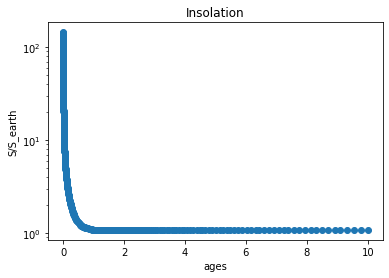

In [4]:
teff_evo = []
rad_evo = []

importeddata = np.genfromtxt(infile, delimiter=",", usecols=(0,2,3,5,6), skip_header=1)
stellar_teff = importeddata[:,1]
stellar_rad = importeddata[:,3]
teff_evo.append(stellar_teff)
rad_evo.append(stellar_rad)

F_planirr = []
for i in range(0,len(teff_evo)):
    Temp = teff_evo[i]/5778
    sqrt = np.sqrt(1./(1-ecc**2))
    F = ((rad_evo[i])**2)*((Temp)**4)*((orbital_radius/1.496e+8)**(-2))*(sqrt) #change semi-major axis
    F_planirr.append(F)
    
    plt.title('Insolation')
    plt.plot(ages,F,'o',linewidth=8)
    plt.ylabel('S/S_earth')
    plt.xlabel('ages')
    plt.yscale('log')


**Modeling Photoevaporation induced atmospheric escape**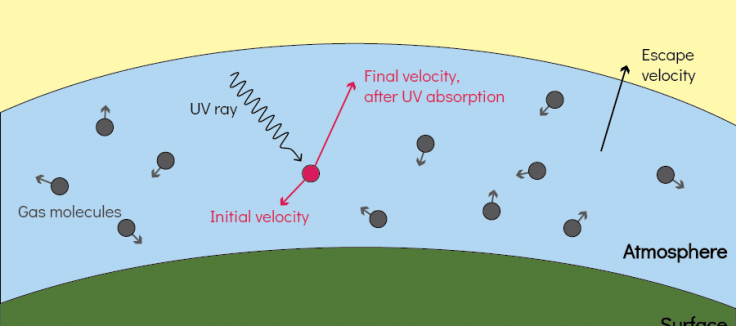

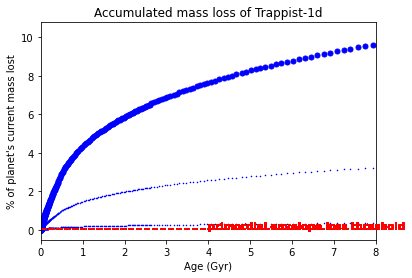

In [10]:
#doing initial calculations
mass_core=(planet_mass-((envelope_fraction/100)*planet_mass))
radius_core=planet_radius-(2.06*6378*((planet_mass/5.972e+27)**-0.21)*((envelope_fraction/5)**0.59)*((F[300])**0.044)*((stellar_age/5)**-0.18)) #planet radius- radius of the envelope (km)
mass_env_initial = (p_frac/100)*planet_mass #this is the primordial envelope mass (what we are starting with in for loop)
mass_planet_initial=(planet_mass-((envelope_fraction/100)*planet_mass))+mass_env_initial #primordial planet mass
radius_planet_initial=radius_core+(2.06*6378*((mass_planet_initial/5.972e+27)**-0.21)*((p_frac/5)**0.59)*((F[0])**0.044)*((0.0005/5)**-0.18)) #primordial planet radius

#setting initial conditions
Renv=0 
Renv_upper=0
Renv_lower=0
mass_lost_overtime=0
mass_lost_overtime_upper=0
mass_lost_overtime_lower=0
mdot=0
mdot_upper=0
mdot_lower=0
new_mass = mass_planet_initial
new_mass_upper = mass_planet_initial
new_mass_lower = mass_planet_initial
new_radius = radius_planet_initial
new_radius_upper = radius_planet_initial
new_radius_lower = radius_planet_initial
mass_env=mass_env_initial 
mass_env_upper=mass_env_initial 
mass_env_lower=mass_env_initial 

G = 6.6743e-8 # cm^3 g^-1 s^-2

#beginning actual calculations
mdot_M = []
for j in range(0,len(ages)-1):  #-1 because the last item has no difference!
  if ages[j] < 0.5:
    log_L_x=-0.308*np.log10(ages[j])+28.333 #erg/s
    F_x=(10**log_L_x)/(4*3.14*(stellar_rad*6.957e+8)**2) #erg/s/m^2
    Fx_W = F_x*1e-7 #in W/m2
    Fx_mW = Fx_W*1e3 #in mW/m2
    logFx = np.log10(Fx_mW)
    logFeuv = 2.63 + 0.58*logFx
    Feuv_1 = 10**logFeuv #em mW/m2
    Feuv = (Feuv_1*1e7*1e-3) #in erg/s/m2 
    Leuv = Feuv*(4*np.pi*(stellar_rad*6.957e+8)**2) #Luminosity of the star [ERG/S]
    Fp = Leuv/(4*np.pi*(orbital_radius*1000)**2) #erg/s/m2
    Fp_cm = Leuv/(4*np.pi*(orbital_radius*100000)**2) #erg/s/cm2

  if ages[j] > 0.5:
    log_L_x=-1.4214*np.log10(ages[j])+27.826
    F_x=(10**log_L_x)/(4*3.14*(stellar_rad*6.957e+8)**2)
    Fx_W = F_x*1e-7 #in W/m2
    Fx_mW = Fx_W*1e3 #in mW/m2
    logFx = np.log10(Fx_mW)
    logFeuv = 2.63 + 0.58*logFx
    Feuv_1 = 10**logFeuv #em mW/m2
    Feuv = (Feuv_1*1e7*1e-3) #in erg/s/m2 
    Leuv = Feuv*(4*np.pi*(stellar_rad*6.957e+8)**2) #Luminosity of the star [ERG/S]
    Fp = Leuv/(4*np.pi*(orbital_radius*1000)**2) #erg/s/m2
    Fp_cm = Leuv/(4*np.pi*(orbital_radius*100000)**2) #erg/s/cm2

  mdot = (0.3*np.pi*Fp_cm*(new_radius*100000)**3 /(G*(new_mass)))*3.1536e+16 # in g/Gyr
  mdot_upper=(0.1*np.pi*Fp_cm*(new_radius_upper*100000)**3 /(G*(new_mass_upper)))*3.1536e+16 # in g/Gyr
  mdot_lower=(0.01*np.pi*Fp_cm*(new_radius_lower*100000)**3 /(G*(new_mass_lower)))*3.1536e+16 # in g/Gyr

  #new_mass = new_mass-(diff[j]*mdot) #new mass of the planet in g after adding in the mass lost 
  mass_env = mass_env-(diff[j]*mdot) #new mass of the envelope in g
  mass_env_upper=mass_env_upper-(diff[j]*mdot_upper)
  mass_env_lower=mass_env_lower-(diff[j]*mdot_lower)
  #new_mass=mass_core+mass_env

  if mass_env >= 0:
    frac_env = ((mass_env)/planet_mass)*100 #new envelope fraction
    new_mass=mass_core+mass_env
  if mass_env_upper >= 0:
    frac_env_upper = ((mass_env_upper)/planet_mass)*100 #new envelope fraction
    new_mass_upper=mass_core+mass_env_upper
  if mass_env_lower >= 0:
    frac_env_lower = ((mass_env_lower)/planet_mass)*100 #new envelope fraction
    new_mass_lower=mass_core+mass_env_lower

  if mass_env<0:
    frac_env=0
    new_mass=mass_core
  if mass_env_upper<0:
    frac_env_upper=0
    new_mass_upper=mass_core
  if mass_env_lower<0:
    frac_env_lower=0
    new_mass_lower=mass_core

  Renv = 2.06*6378*((new_mass/5.972e+27)**-0.21)*((frac_env/5)**0.59)*((F[j])**0.044)*((ages[j]/5)**-0.18) #new radius of the envelope (km)
  Renv_upper = 2.06*6378*((new_mass_upper/5.972e+27)**-0.21)*((frac_env_upper/5)**0.59)*((F[j])**0.044)*((ages[j]/5)**-0.18) #new radius of the envelope (km)
  Renv_lower = 2.06*6378*((new_mass_lower/5.972e+27)**-0.21)*((frac_env_lower/5)**0.59)*((F[j])**0.044)*((ages[j]/5)**-0.18) #new radius of the envelope (km)

  new_radius = radius_core+Renv #new planet radius (km)
  new_radius_upper = radius_core+Renv_upper #new planet radius (km)
  new_radius_lower = radius_core+Renv_lower #new planet radius (km)

  mass_lost_overtime=mass_lost_overtime+diff[j]*mdot
  mass_lost_overtime_upper=mass_lost_overtime_upper+diff[j]*mdot_upper
  mass_lost_overtime_lower=mass_lost_overtime_lower+diff[j]*mdot_lower

  #plotting mass lost overtime -- can substitute for any plot of desire
  plt.plot(ages[j],(mass_lost_overtime/planet_mass)*100, 'o', color='blue', markersize=5)
  plt.plot(ages[j],(mass_lost_overtime_upper/planet_mass)*100, '*', color='blue', markersize=1)
  plt.plot(ages[j],(mass_lost_overtime_lower/planet_mass)*100, '*', color='blue', markersize=1)
  plt.axhline(y = p_frac, color = 'r', linestyle = '--')
  plt.text(4, p_frac*1.1, 'primordial envelope loss threshold', color='red', weight='bold')
  plt.title('Accumulated mass loss of' +' '+planet_name )
  plt.xlabel('Age (Gyr)')
  plt.ylabel("% of planet's current mass lost")
  plt.xlim(0,stellar_age)



**Modelling Stellar Wind induced atmospheric escape**
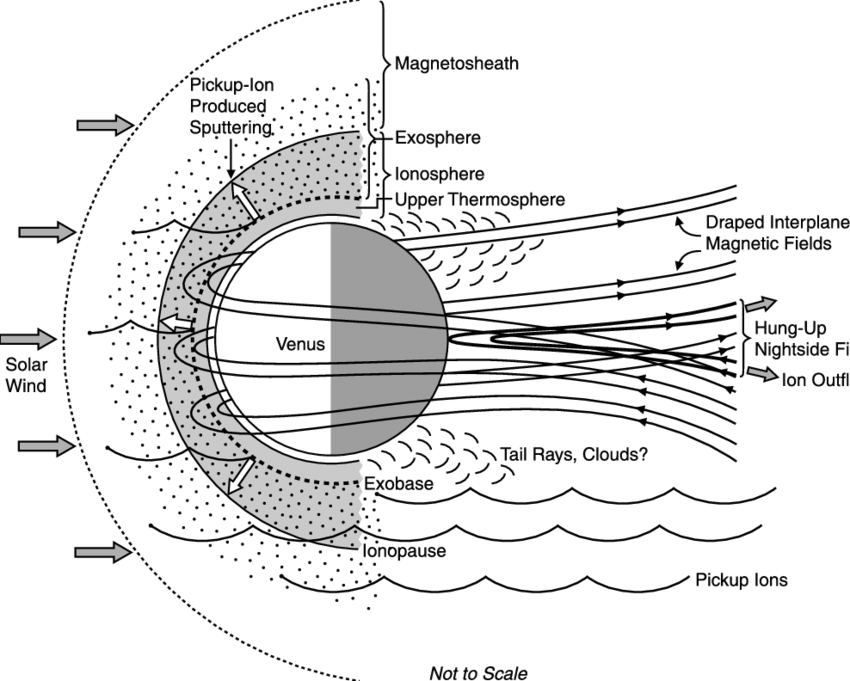

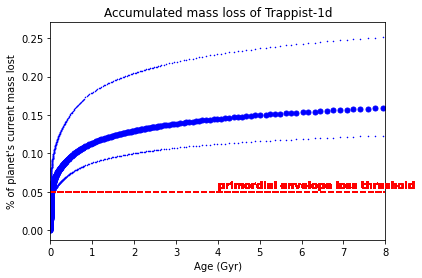

In [8]:
#doing initial calculations
radius_core=planet_radius-(2.06*6378*((planet_mass/5.972e+27)**-0.21)*((envelope_fraction/5)**0.59)*((F[300])**0.044)*((stellar_age/5)**-0.18)) #planet radius- radius of the envelope (km)
mass_env_initial = (p_frac/100)*planet_mass #this is the primordial envelope mass (what we are starting with in for loop)
mass_planet_initial=(planet_mass-((envelope_fraction/100)*planet_mass))+mass_env_initial #primordial planet mass
radius_planet_initial=radius_core+(2.06*6378*((mass_planet_initial/5.972e+27)**-0.21)*((p_frac/5)**0.59)*((F[0])**0.044)*((0.0005/5)**-0.18)) #primordial planet radius
mass_core=(planet_mass-((envelope_fraction/100)*planet_mass))

#setting initial conditions
Renv=0 
Renv_upper=0
Renv_lower=0
mass_lost_overtime=0
mass_lost_overtime_upper=0
mass_lost_overtime_lower=0
mdot=0
mdot_upper=0
mdot_lower=0
new_mass = mass_planet_initial
new_mass_upper = mass_planet_initial
new_mass_lower = mass_planet_initial
new_radius = radius_planet_initial
new_radius_upper = radius_planet_initial
new_radius_lower = radius_planet_initial
mass_env=mass_env_initial 
mass_env_upper=mass_env_initial 
mass_env_lower=mass_env_initial 

#beginning actual calculations
mdot_M = []
for j in range(0,len(ages)-1):  #-1 because the last item has no difference!

  if stellar_type=='M2.5-6.0V':
    P_rot= 15.829*ages[j]+2.233
    P_rot_upper=15.195*ages[j]
    P_rot_lower=16.463*ages[j]+5.762
    if ages[j] < 0.5:
      L_x=-0.308*np.log(ages[j])+28.333
      F_x=(10**L_x)/(4*3.14*(stellar_rad*696340*1E5)**2)
      T=0.11*(F_x)**0.26
    if ages[j] > 0.5:
      L_x=-1.4214*np.log(ages[j])+27.826
      F_x=(10**L_x)/(4*3.14*(stellar_rad*696340*1E5)**2)
      T=0.11*(F_x)**0.26

  if stellar_type=='M8V':
    P_rot= 0.375*ages[j]
    P_rot_upper=0.175*ages[j]
    P_rot_lower=0.575*ages[j]
    if ages[j] < 0.5:
      L_x=-0.308*np.log(ages[j])+28.333
      F_x=(10**L_x)/(4*3.14*(stellar_rad*696340*1E5)**2)
      T=0.11*(F_x)**0.26
    if ages[j] > 0.5:
      L_x=-1.4214*np.log(ages[j])+27.826
      F_x=(10**L_x)/(4*3.14*(stellar_rad*696340*1E5)**2)
      T=0.11*(F_x)**0.26

  if stellar_type=='M0V':
    if ages[j]<0.2:
      P_rot=0.0001
      P_rot_upper=0.0001
      P_rot_lower=0.0001
    if ages[j]>0.2:
      P_rot=-4.962+16.548*ages[j]**0.669
      P_rot_upper=-4.962+16.548*ages[j]**0.669
      P_rot_lower=-4.962+16.548*ages[j]**0.669
    if ages[j] < 0.5:
      L_x=-0.308*np.log(ages[j])+28.333 #X-ray luminosity 
      F_x=(10**L_x)/(4*3.14*(stellar_rad*696340*1E5)**2) #X-ray flux
      T=0.11*(F_x)**0.26 #coronal temperature
    if ages[j] > 0.5:
      L_x=-1.4214*np.log(ages[j])+27.826 #X-ray luminosity 
      F_x=(10**L_x)/(4*3.14*(stellar_rad*696340*1E5)**2) #X-ray flux
      T=0.11*(F_x)**0.26 #coronal temperature
  
  v_c = 180*(((T*1E6)/2E6)**0.5) #critical velocity in km/s
  r_c= (2E11)*(stellar_mass)*(((T*1E6)/2E6)**-1) #critical radius in cm
  
  if radii=='small radii': #when r<<r_s
    wind_velocity = (v_c*np.exp(3/2))*np.exp((-2*r_c)/(orbital_radius*1E5)) #wind velocity in km/s
  
  if radii=='large radii': #when r>>r_s
    wind_velocity= 2*v_c*(np.log((orbital_radius*1E5)/r_c)**0.5) #wind velocity in km/s
  
  wind_density = ((3.3E5*(orbital_radius*10**5/r_sun)**-2 + 4.16E6*(orbital_radius*1E5/r_sun)**-4 + 8.0E7*(orbital_radius*1E5/r_sun)**-6)*(M_H/2)*(27.2/P_rot)**0.6) #wind density in g/cm^3 (rot)
  wind_density_upper = ((3.3E5*(orbital_radius*10**5/r_sun)**-2 + 4.16E6*(orbital_radius*1E5/r_sun)**-4 + 8.0E7*(orbital_radius*1E5/r_sun)**-6)*(M_H/2)*(27.2/P_rot_upper)**0.6) #wind density in g/cm^3 (rot)
  wind_density_lower = ((3.3E5*(orbital_radius*10**5/r_sun)**-2 + 4.16E6*(orbital_radius*1E5/r_sun)**-4 + 8.0E7*(orbital_radius*1E5/r_sun)**-6)*(M_H/2)*(27.2/P_rot_lower)**0.6) #wind density in g/cm^3 (rot)

  mdot = 0.3*6.28*((new_radius)**2)*(wind_density*10**15)*(wind_velocity)*3.1536e+16 #mass loss rate in g/Gyr
  mdot_upper = 0.3*6.28*((new_radius)**2)*(wind_density_upper*10**15)*(wind_velocity)*3.1536e+16 #mass loss rate in g/Gyr
  mdot_lower = 0.3*6.28*((new_radius)**2)*(wind_density_lower*10**15)*(wind_velocity)*3.1536e+16 #mass loss rate in g/Gyr

  mass_env = mass_env-(diff[j]*mdot) #new mass of the envelope in g
  mass_env_upper = mass_env-(diff[j]*mdot_upper)
  mass_env_lower = mass_env-(diff[j]*mdot_lower)


  if mass_env >= 0:
    frac_env = ((mass_env)/planet_mass)*100 #new envelope fraction
    new_mass=mass_core+mass_env
  if mass_env_upper >= 0:
    frac_env_upper = ((mass_env_upper)/planet_mass)*100
    new_mass_upper=mass_core+mass_env_upper
  if mass_env_lower >= 0:
    frac_env_lower = ((mass_env_lower)/planet_mass)*100
    new_mass_lower=mass_core+mass_env_lower

  if mass_env<0:
    frac_env=0
  if mass_env_upper<0:
    frac_env_upper=0
  if mass_env_lower<0:
    frac_env_lower=0


  Renv = 2.06*6378*((new_mass/5.972e+27)**-0.21)*((frac_env/5)**0.59)*((F[j])**0.044)*((ages[j]/5)**-0.18) #new radius of the envelope (km)
  Renv_upper = 2.06*6378*((new_mass_upper/5.972e+27)**-0.21)*((frac_env_upper/5)**0.59)*((F[j])**0.044)*((ages[j]/5)**-0.18) #new radius of the envelope (km)
  Renv_lower = 2.06*6378*((new_mass_lower/5.972e+27)**-0.21)*((frac_env_lower/5)**0.59)*((F[j])**0.044)*((ages[j]/5)**-0.18) #new radius of the envelope (km)

  new_radius = radius_core+Renv #new planet radius (km)
  new_radius_upper = radius_core+Renv_upper
  new_radius_lower = radius_core+Renv_lower

  mass_lost_overtime=mass_lost_overtime+diff[j]*mdot
  mass_lost_overtime_upper= mass_lost_overtime_upper +diff[j]*mdot_upper
  mass_lost_overtime_lower= mass_lost_overtime_lower +diff[j]*mdot_lower

  plt.plot(ages[j],(mass_lost_overtime/planet_mass)*100, 'o', color='blue', markersize=5)
  plt.plot(ages[j],(mass_lost_overtime_upper/planet_mass)*100, '*', color='blue', markersize=1)
  plt.plot(ages[j],(mass_lost_overtime_lower/planet_mass)*100, '*', color='blue', markersize=1)
  plt.axhline(y = p_frac, color = 'r', linestyle = '--')
  plt.text(4, p_frac*1.1, 'primordial envelope loss threshold', color='red', weight='bold')
  plt.title('Accumulated mass loss of' +' '+planet_name )
  plt.xlabel('Age (Gyr)')
  plt.ylabel("% of planet's current mass lost")
  plt.xlim(0,stellar_age)
